* si pn veut Limiter la base à nb classes (qui ont le plus d'images)

In [42]:
#############################################################################################
# from LFW dataset, we just keep classes (persons) with more than one face image
############################################################################################
def define_classes(class_dir, nb):
  my_dict={}
  for lst_dir in os.listdir(class_dir):
    my_dict[lst_dir]= len(image_files_in_folder(os.path.join(class_dir, lst_dir)))
  
  my_dict=sorted(my_dict.items(), key=lambda x: x[1], reverse=True)
  classes=list()
  for i in range(nb):
    classes.append(my_dict[i][0])
  return classes

* Fonction de calcul des caractéristiques (pose, encodings et classes)

In [43]:
###############################################################################################
# in this programme, we evaluated facenet 128 features
##############################################################################################

def extract_features_from_images (class_dir, nb):
    poses=[] # vecteur des valeurs de poses 
    encodings_facenet=[] # vecteur des encodings

    classes=[] # labels of faces (person identity)
    
    lst_classes=define_classes(class_dir, nb)
    
    for lst_dir in lst_classes:
        if not os.path.isdir(os.path.join(class_dir, lst_dir)):
            continue
        
        for img_path in image_files_in_folder(os.path.join(class_dir, lst_dir)):
            
            # Chargement de l'image
            image = face_recognition.load_image_file(img_path)
            
            # DETECTION DES VISAGES
            face_bounding_boxes = face_recognition.face_locations(image)
            
            if len(face_bounding_boxes) != 1:
                print("Image {} not suitable for training: {}".format(img_path, "   Didn't find a face" if len(face_bounding_boxes) < 1 else "   Found more than one face"))
            else:
                faces=detector(image) # will be defined in the principal programme
                for face in faces:
                  marks=landmark_model(image, face)
                  marks=face_utils.shape_to_np(marks)

                pose=get_head_pose(marks)
                poses.append(np.array(pose))
                         
                # EXTRACTION DES 128 FEATURES 
                encoding_facenet=(face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0])
                encodings_facenet.append(np.array(encoding_facenet))
            

                
                # Labels: person identity
                classes.append(lst_dir)
              
                print("image:" , img_path, "    pose:", pose, "     person identity:", lst_dir )
        
    poses=np.asarray(poses)
    encodings_facenet=np.asarray(encodings_facenet)

    classes=np.asarray(classes)
    
    return poses, encodings_facenet, classes

* Execution du programme de calcul des features

In [44]:
######################################################
########    PROGRAMME PRINCIPAL   ####################
###########  Features extraction  ####################
########  poses, encodings, lbp, classes #############
######################################################
import math
from sklearn import neighbors
import os
import os.path
import pickle
#from PIL import Image, ImageDraw

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import face_recognition
from face_recognition.face_recognition_cli import image_files_in_folder
from detector_lib import *
import imutils
from imutils import face_utils
from imutils.face_utils import FaceAligner, rect_to_bb, helpers

from skimage import feature
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score
#from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
#from sklearn.linear_model import Ridge
#from sklearn.preprocessing import PolynomialFeatures
#from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}

# Extraction des caracteristique a partir de la base des images
print('#INFO: Extraction des caracteristiques...')
class_dir = 'pose_dataset'
try:
  with open("data_features_facenet_pose.pickle", "rb") as f1:
    poses, encodings_facenet, classes = pickle.load(f1) #landmarks
except:
  nb_classes=15
  detector=dlib.get_frontal_face_detector()
  landmark_model=dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
  poses, encodings_facenet, classes = extract_features_from_images (class_dir, nb_classes)
  with open("data_features_facenet_pose.pickle", "wb") as f1:
    pickle.dump((poses, encodings_facenet, classes), f1)

poses = np.array(poses)
encodings_facenet = np.array(encodings_facenet)

classes = np.array(classes)
print('poses shape:', poses.shape)
print('encodings facenet shape:', encodings_facenet.shape)

print('classes shape:', classes.shape)
print('Nombre total de classes:', np.unique(classes).shape[0])

#INFO: Extraction des caracteristiques...
poses shape: (1454,)
encodings facenet shape: (1454, 128)
classes shape: (1454,)
Nombre total de classes: 15


Modèle 1 (Sans regression):
* Train: 2/3 (1745 images)
* Test: 1/3 (860 images)

In [45]:
#################################################
######## SUITE PROGRAMME PRINCIPAL ##############
######## Tester les pferformances du descripteur sur une base complète  ##############
######## Train=0.66 and test=0.33  ##############
#################################################
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn.metrics import classification_report, confusion_matrix

# define classifiers
KNN_clf = neighbors.KNeighborsClassifier(n_neighbors=1)
SVC_clf = SVC(kernel='rbf',probability=True)
LR_clf=LogisticRegression()
RF_clf=RandomForestClassifier(n_estimators=500)
# choix de type de features (facenet)
encodings = encodings_facenet 
features_nb=encodings.shape[1]
# Diviser la base db2 en train (2/3) et test (1/3)
encodings_db2_train_model1, encodings_db2_test_model1, classes_db2_train_model1, \
classes_db2_test_model1, poses_db2_train_model1, poses_db2_test_model1 =  train_test_split(
    encodings, 
    classes, 
    poses, 
    test_size=0.33, 
    random_state=42)

print('db2 training samples (model 1):', encodings_db2_train_model1.shape)
print('db2 test samples (model 1):', encodings_db2_test_model1.shape)

# Train classifiers
print('Fitting  ...')
KNN_clf.fit (encodings_db2_train_model1 , classes_db2_train_model1)
SVC_clf.fit (encodings_db2_train_model1 , classes_db2_train_model1)
LR_clf.fit (encodings_db2_train_model1 , classes_db2_train_model1)

RF_clf.fit (encodings_db2_train_model1 , classes_db2_train_model1)

print('Evaluate classifiers')
# Evaluate the classifiers algorithms

Accuracy_KNN_full_dataset = accuracy_score(classes_db2_test_model1, KNN_clf.predict(encodings_db2_test_model1))*100
Accuracy_SVC_full_dataset = accuracy_score(classes_db2_test_model1, SVC_clf.predict(encodings_db2_test_model1))*100
Accuracy_LR_full_dataset = accuracy_score(classes_db2_test_model1, LR_clf.predict(encodings_db2_test_model1))*100
Accuracy_RF_full_dataset = accuracy_score(classes_db2_test_model1, RF_clf.predict(encodings_db2_test_model1))*100
print("Accuracy_KNN_full_dataset:", Accuracy_KNN_full_dataset)
evaluation_full_dataset ={'KNN :': Accuracy_KNN_full_dataset, 'SVC' :Accuracy_SVC_full_dataset, 'LR':Accuracy_LR_full_dataset,\
                          'RF':Accuracy_RF_full_dataset}
for i in evaluation_full_dataset.items():
    print(i)                         

db2 training samples (model 1): (974, 128)
db2 test samples (model 1): (480, 128)
Fitting  ...
Evaluate classifiers
Accuracy_KNN_full_dataset: 99.58333333333333
('KNN :', 99.58333333333333)
('SVC', 99.16666666666667)
('LR', 98.95833333333334)
('RF', 99.58333333333333)


In [46]:
#################################################
######## SUITE PROGRAMME PRINCIPAL ##############
######## Tester les performances du descripteur sur une base réduite 1 image per person ##############
########    Train = only 1 image   ##############
#################################################

# Pour chaque classe, choisir 1 image pour Train (pose ~= 0)
poses_db2_train_model2=[]
poses_db2_test_model2=[]

encodings_db2_train_model2=[]
encodings_db2_test_model2=[]


classes_db2_train_model2=[]
classes_db2_test_model2=[]

unique_classes_db2=np.unique(classes)
classes_nb =unique_classes_db2.shape[0]
for i in range(classes_nb):
  idx_classes=np.where(classes==unique_classes_db2[i])
  idx_min= np.abs(poses[idx_classes]).argmin() # idx_min dans idx_classes
  idx_train=idx_classes[0][idx_min]
  idx_test=np.delete(idx_classes, idx_min)
  
  poses_db2_train_model2.append(poses[idx_train])
  encodings_db2_train_model2.append(encodings[idx_train])
  #encodings_lbp_db2_train_model2.append(encodings_lbp[idx_train])
  classes_db2_train_model2.append(classes[idx_train])
  
  for j in range(len(idx_test)):
    poses_db2_test_model2.append(poses[idx_test][j])
    encodings_db2_test_model2.append(encodings[idx_test][j])
    #encodings_lbp_db2_test_model2.append(encodings_lbp[idx_test][j])
    classes_db2_test_model2.append(classes[idx_test][j])
    
poses_db2_train_model2=np.array(poses_db2_train_model2)
poses_db2_test_model2=np.array(poses_db2_test_model2)

encodings_db2_train_model2=np.array(encodings_db2_train_model2)
encodings_db2_test_model2=np.array(encodings_db2_test_model2)


classes_db2_train_model2=np.array(classes_db2_train_model2)
classes_db2_test_model2=np.array(classes_db2_test_model2)

print('db2 training samples (model 2):', encodings_db2_train_model2.shape[0])
print('db2 test samples (model 2):', encodings_db2_test_model2.shape[0])

# Train classifiers
print('Fitting  ...')
KNN_clf.fit (encodings_db2_train_model2 , classes_db2_train_model2)
SVC_clf.fit (encodings_db2_train_model2 , classes_db2_train_model2)
LR_clf.fit (encodings_db2_train_model2 , classes_db2_train_model2)
RF_clf.fit (encodings_db2_train_model2 , classes_db2_train_model2)

# Evaluate classifiers
print('Evaluate classifiers ...')
#Accuracy_KNN_reduced_dataset = accuracy_score(classes, KNN_clf.predict(encodings))*100
Accuracy_KNN_reduced_dataset = accuracy_score(classes_db2_test_model2, KNN_clf.predict(encodings_db2_test_model2))*100
Accuracy_SVC_reduced_dataset = accuracy_score(classes_db2_test_model2, SVC_clf.predict(encodings_db2_test_model2))*100
Accuracy_LR_reduced_dataset = accuracy_score(classes_db2_test_model2, LR_clf.predict(encodings_db2_test_model2))*100
Accuracy_RF_reduced_dataset = accuracy_score(classes_db2_test_model2, RF_clf.predict(encodings_db2_test_model2))*100


#print ('Accuracy KNN reduced dataset vs full dataset:', Accuracy_KNN_reduced_dataset , Accuracy_KNN_full_dataset)
#print ('Accuracy SVC reduced dataset vs full dataset:', Accuracy_SVC_reduced_dataset, Accuracy_SVC_full_dataset)
#print ('Accuracy LR  reduced dataset vs full dataset:', Accuracy_LR_reduced_dataset, Accuracy_LR_full_dataset)
#print ('Accuracy RF  reduced dataset vs ful dataset:', Accuracy_RF_reduced_dataset, Accuracy_RF_full_dataset)

evaluation_reduced_dataset ={'KNN_reduced_dataset :': Accuracy_KNN_reduced_dataset, \
                             'SVC_reduced_dataset' :Accuracy_SVC_reduced_dataset,\
                          'LR_reduced_dataset':Accuracy_LR_reduced_dataset,\
                          'RF_reduced_dataset':Accuracy_RF_reduced_dataset}
# re afficher egalement les résultats sur la base complète pour comparer
for i in evaluation_full_dataset.items():
    print(i) 
for i in evaluation_reduced_dataset.items():
    print(i)

db2 training samples (model 2): 15
db2 test samples (model 2): 1439
Fitting  ...
Evaluate classifiers ...
('KNN :', 99.58333333333333)
('SVC', 99.16666666666667)
('LR', 98.95833333333334)
('RF', 99.58333333333333)
('KNN_reduced_dataset :', 91.73036831132731)
('SVC_reduced_dataset', 91.73036831132731)
('LR_reduced_dataset', 89.64558721334261)
('RF_reduced_dataset', 85.89298123697013)


In [48]:

def generate_gauss(sigma, features, poses, classes, nb_generate):
    gen_features=[] # generate feature for all perons 
    gen_classes = [] # generate class for all persons
    
    for person in np.unique(classes):
        idx_person=np.where(classes == person)[0] # indices la la personne person
        idx_person_min_pos= np.abs(poses[idx_person]).argmin() # l'indice de la pose minimale de la personne person  
        feature = np.array(features[idx_person][idx_person_min_pos])
              
        mu = feature # 128 valeurs de mu
        
        for i in range(nb_generate):
            gen_features.append(random.gauss(mu, sigma))
            gen_classes.append(person)
    gen_features = np.array(gen_features)
    gen_classes = np.array(gen_classes)
    return gen_features, gen_classes

In [50]:
def fit_distribution_gauss (features_train, classes_train, features_test, classes_test,sigma, nb_generate):
   
    gen_features_gauss, gen_classes_gauss = generate_gauss(sigma, features_train, poses, classes_train, nb_generate)
    
        
    ########### Contaténer les features (réels (train) + générés)#################
    all_features_train=[]
    all_features_test=[]
    all_features_train=np.vstack((features_train, gen_features_gauss))
    all_classes_train=np.concatenate((classes_train, gen_classes_gauss), axis=0)

    print('all_features_train shape:', all_features_train.shape)
    print('all_classes_train shape:', all_classes_train.shape)

    #Define classifiers
    KNN_clf = KNeighborsClassifier(n_neighbors=1)
    SVC_clf = SVC(kernel='rbf',probability=True, gamma='scale')
    LR_clf=LogisticRegression(multi_class='auto', solver='lbfgs')
    
    RF_clf=RandomForestClassifier(n_estimators=500)

    print('Fitting  ...')
    # features reeles + distribution gaussienne
    KNN_clf.fit (all_features_train , all_classes_train)
    SVC_clf.fit (all_features_train , all_classes_train)
    LR_clf.fit (all_features_train , all_classes_train)
    RF_clf.fit (all_features_train , all_classes_train)
    

    # sans les features de la distribution gaussienne
    #KNN_clf.fit (features_train , classes_train)
    #SVC_clf.fit (features_train , classes_train)
    #LR_clf.fit (features_train , classes_train)
    #RF_clf.fit (features_train , classes_train)
    #DT_clf.fit (features_train , classes_train)

    # avec distribution gaussienne seulement
    #KNN_clf.fit (gen_features , gen_classes)
    #SVC_clf.fit (gen_features , gen_classes)
    #LR_clf.fit (gen_features , gen_classes)
    #RF_clf.fit (gen_features , gen_classes)
    #DT_clf.fit (gen_features , gen_classes)

    # Evaluate the Knn algorithm
    print('Evaluate classifiers')
    Accuracy_not_adapted_KNN_gauss_based_features = accuracy_score(classes_test, KNN_clf.predict(features_test))*100
    Accuracy_not_adapted_SVC_gauss_based_features = accuracy_score(classes_test, SVC_clf.predict(features_test))*100
    Accuracy_not_adapted_LR_gauss_based_features = accuracy_score(classes_test, LR_clf.predict(features_test))*100
    Accuracy_not_adapted_RF_gauss_based_features = accuracy_score(classes_test, RF_clf.predict(features_test))*100


    evaluation ={'KNN_not_adapted_gauss_prediction :': Accuracy_not_adapted_KNN_gauss_based_features, \
                 'SVC_not_adapted_gauss_prediction' :Accuracy_not_adapted_SVC_gauss_based_features,\
                 'LR_not_adapted_gauss_prediction':Accuracy_not_adapted_LR_gauss_based_features,\
                 'RF_not_adapted_gauss_prediction':Accuracy_not_adapted_RF_gauss_based_features, \
                 }
    return evaluation

sigma=np.arange(0.01, 0.101, 0.01)
generate_vectors=[40, 100, 200]
best_accuracy=0
best_sigma=0
best_generate=0
classifiers=['KNN', 'SVM', 'LR', 'RF']


# split database 
features = encodings_facenet



#features_pose_min, _, _, _ = split_database_1(features, classes)

print('features_train shape:', encodings_db2_train_model2.shape)
print('features_test shape', encodings_db2_test_model2.shape)

for i in sigma:
    for j in generate_vectors:
        print('-------sigma=', i, '-----nb distrubtions:', j)
        evaluation = fit_distribution_gauss(encodings_db2_train_model2, classes_db2_train_model2, \
                                            encodings_db2_test_model2, classes_db2_test_model2,i, j)
        if best_accuracy < max(evaluation.values()):
            best_accuracy = max(evaluation.values())
            best_sigma = i
            best_generate = j
            best_classifier = classifiers[list(evaluation.values()).index(best_accuracy)]
    
print('Best_classifier:', best_classifier, '******* Accuracy=', best_accuracy, \
      '***** best_sigma=', best_sigma, '****** best_generate=', best_generate)

# generate gauss distributions with optimal sigma and number of distributions    


features_train shape: (15, 128)
features_test shape (1439, 128)
-------sigma= 0.01 -----nb distrubtions: 40
all_features_train shape: (615, 128)
all_classes_train shape: (615,)
Fitting  ...
Evaluate classifiers
-------sigma= 0.01 -----nb distrubtions: 100
all_features_train shape: (1515, 128)
all_classes_train shape: (1515,)
Fitting  ...
Evaluate classifiers
-------sigma= 0.01 -----nb distrubtions: 200
all_features_train shape: (3015, 128)
all_classes_train shape: (3015,)
Fitting  ...
Evaluate classifiers
-------sigma= 0.02 -----nb distrubtions: 40
all_features_train shape: (615, 128)
all_classes_train shape: (615,)
Fitting  ...
Evaluate classifiers
-------sigma= 0.02 -----nb distrubtions: 100
all_features_train shape: (1515, 128)
all_classes_train shape: (1515,)
Fitting  ...
Evaluate classifiers
-------sigma= 0.02 -----nb distrubtions: 200
all_features_train shape: (3015, 128)
all_classes_train shape: (3015,)
Fitting  ...
Evaluate classifiers
-------sigma= 0.03 -----nb distrubtions: 4

<ipython-input-57-587a67f9ab4d>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


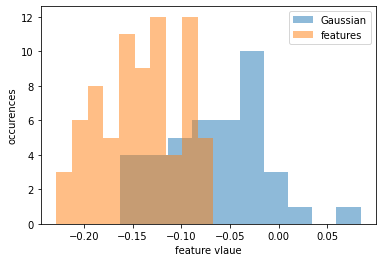

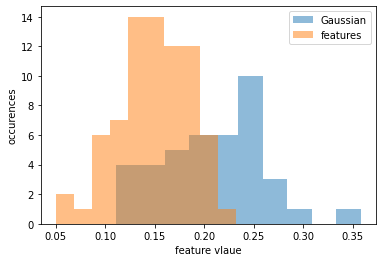

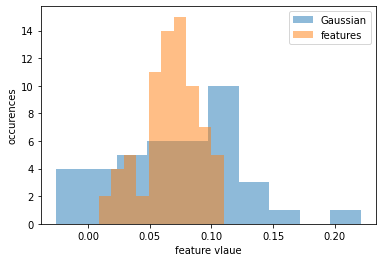

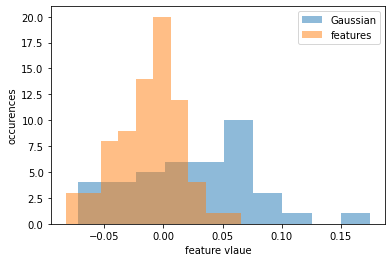

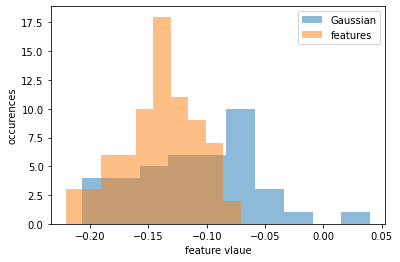

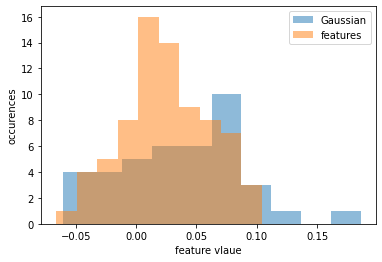

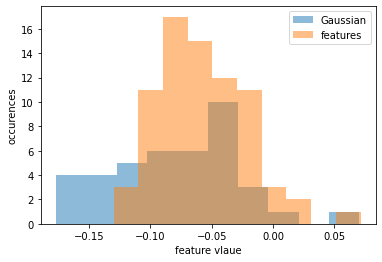

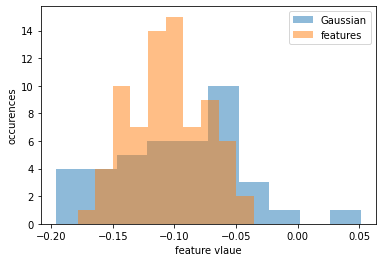

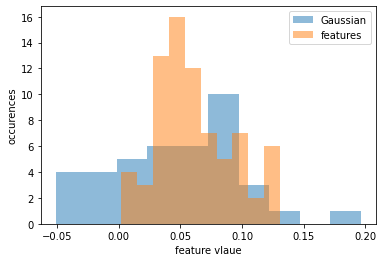

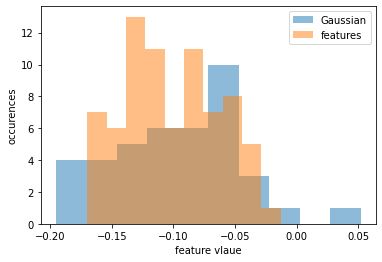

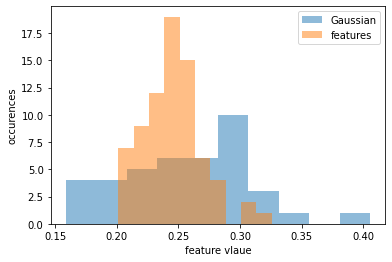

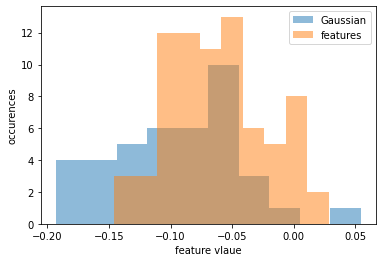

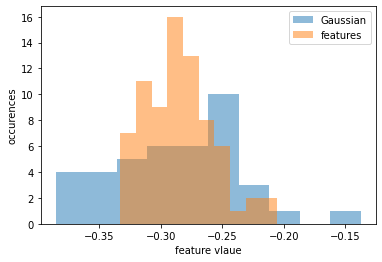

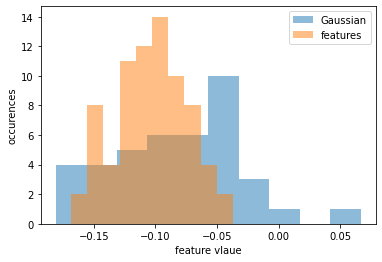

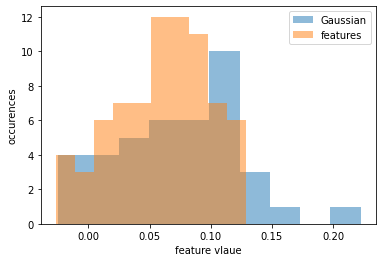

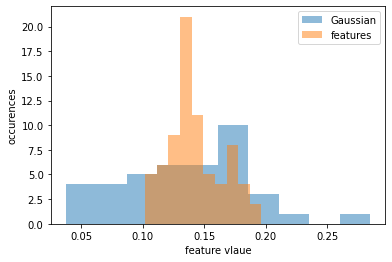

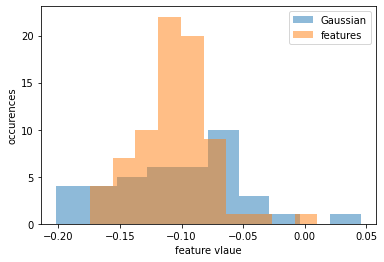

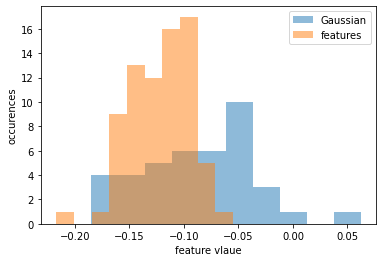

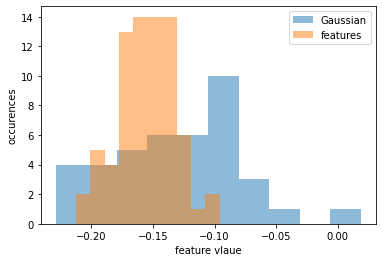

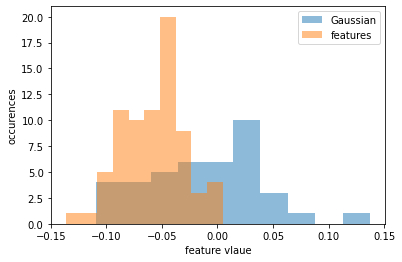

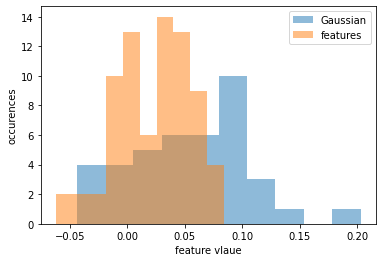

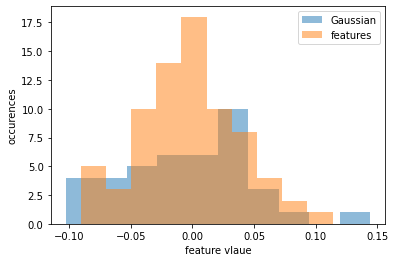

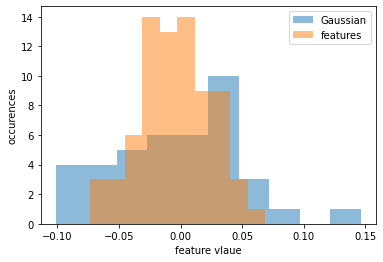

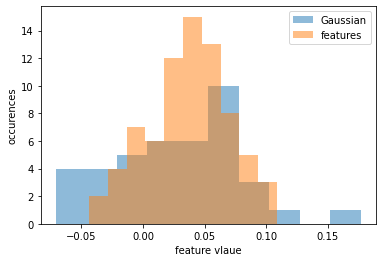

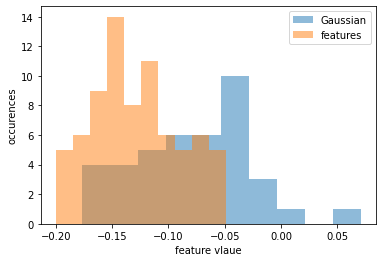

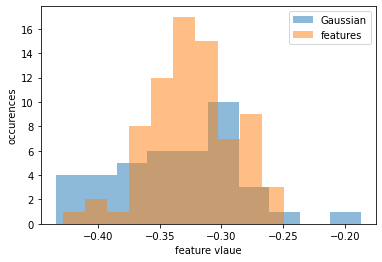

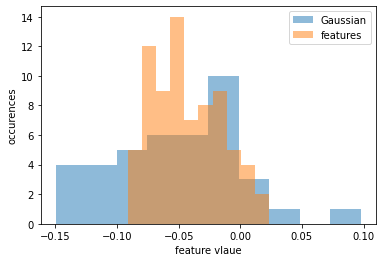

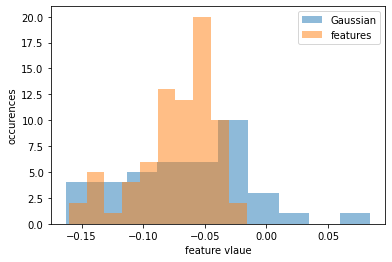

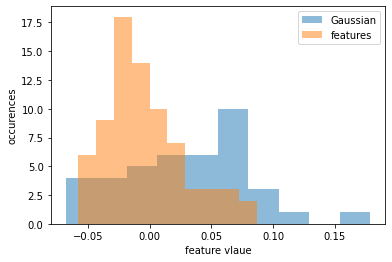

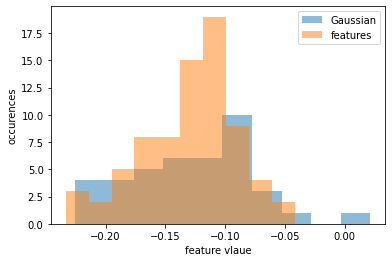

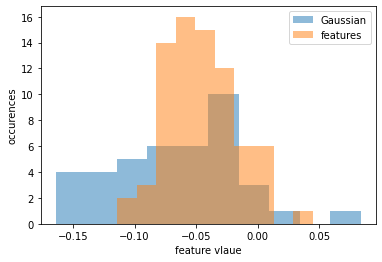

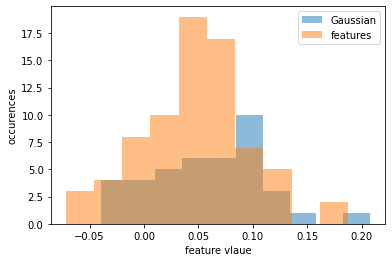

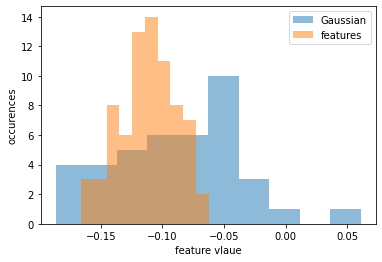

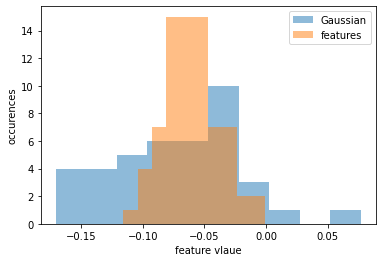

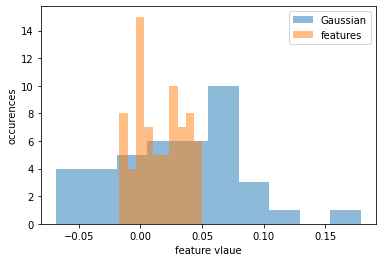

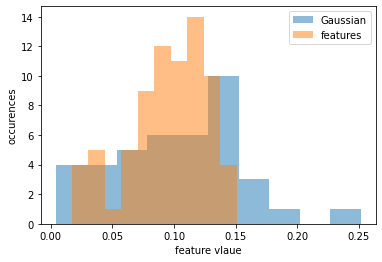

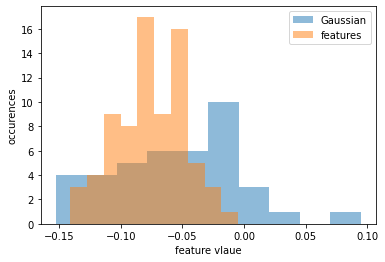

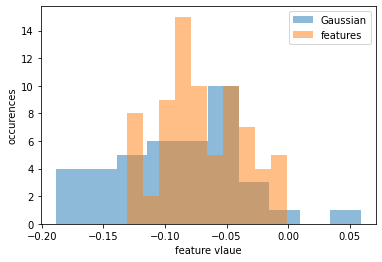

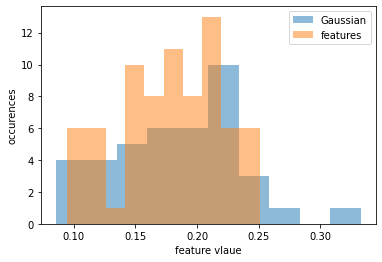

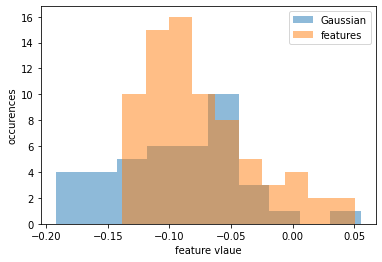

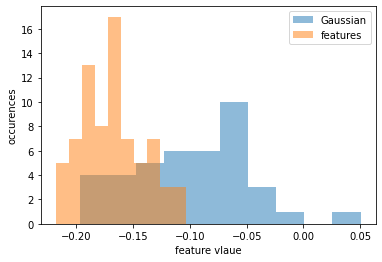

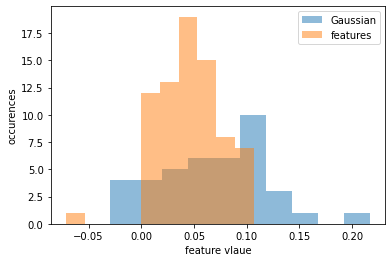

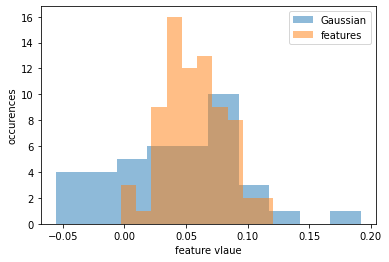

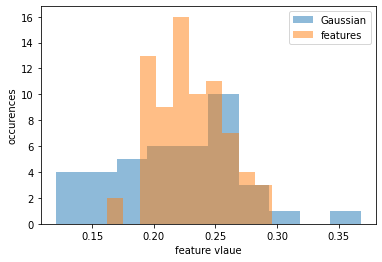

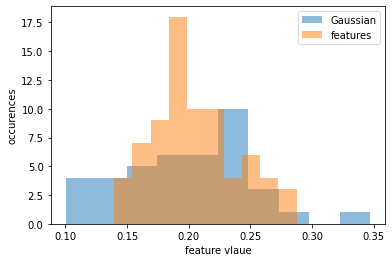

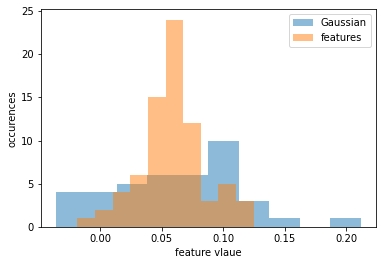

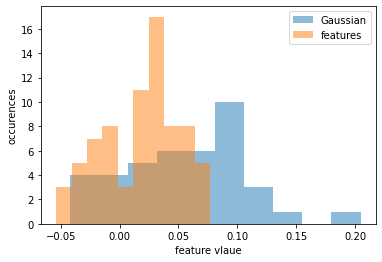

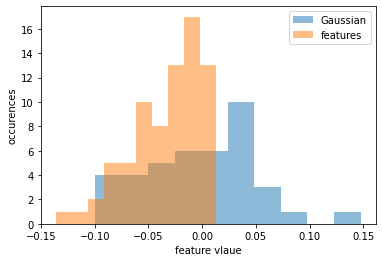

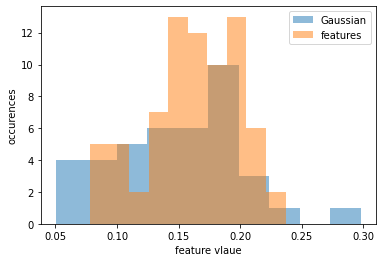

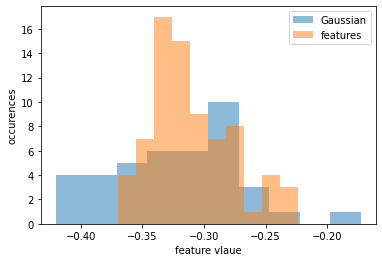

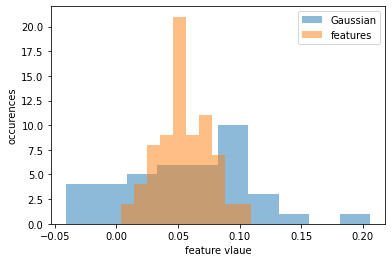

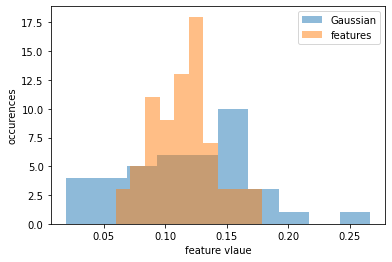

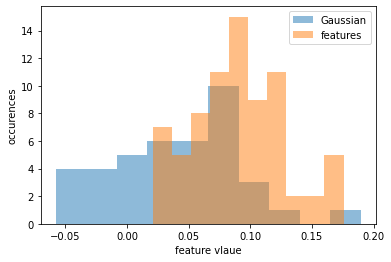

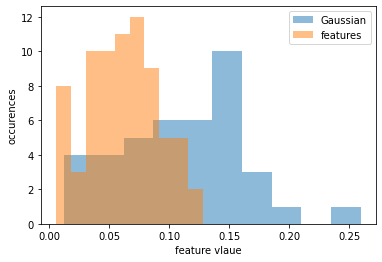

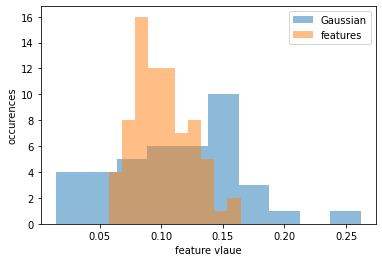

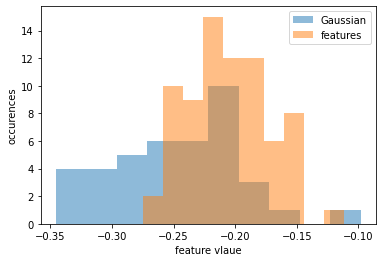

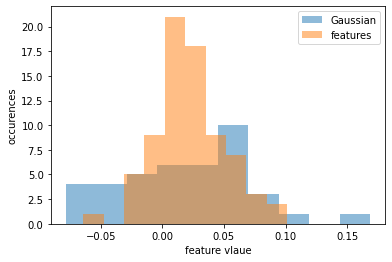

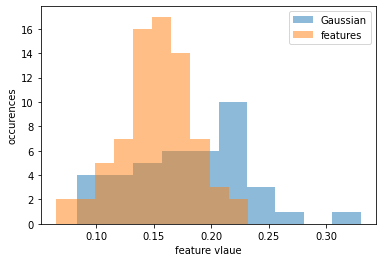

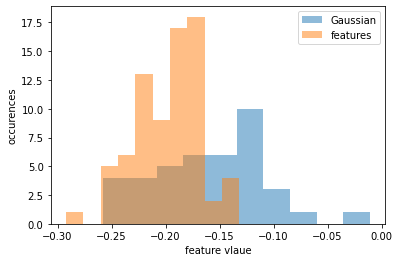

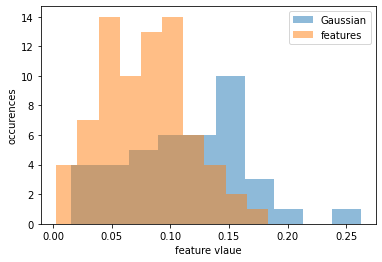

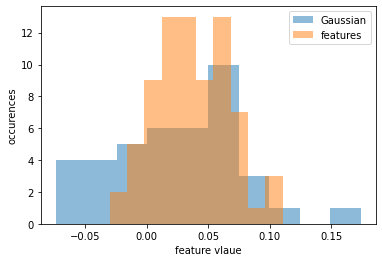

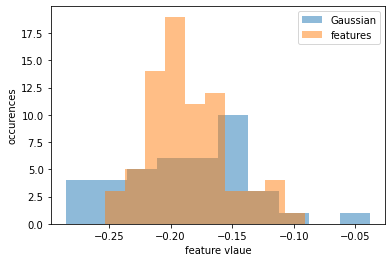

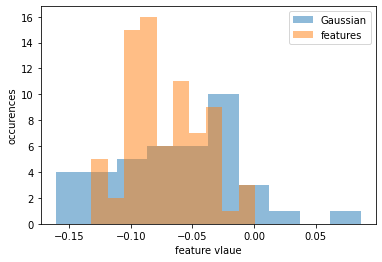

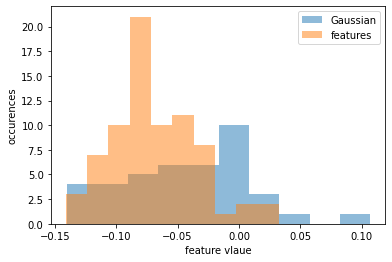

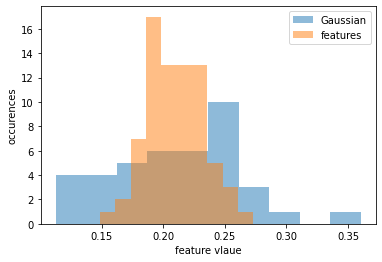

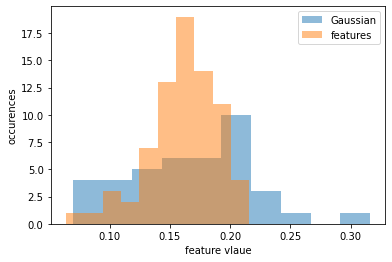

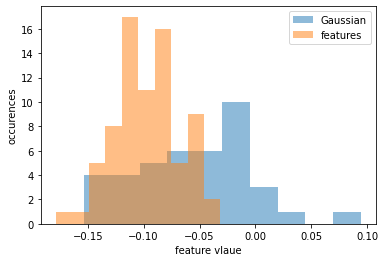

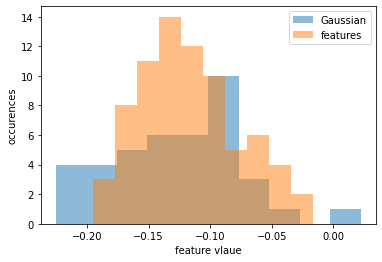

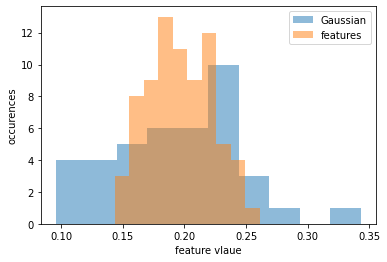

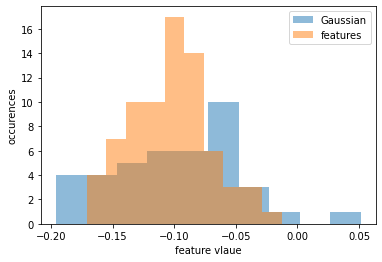

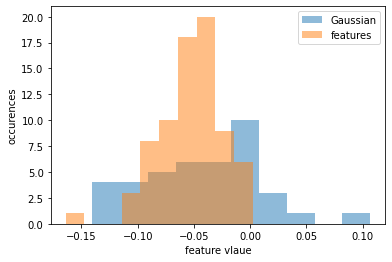

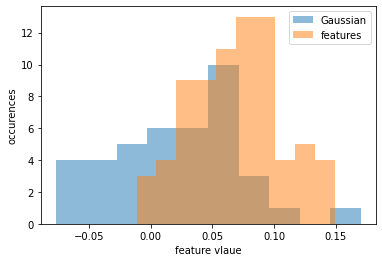

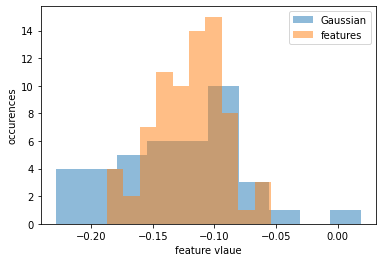

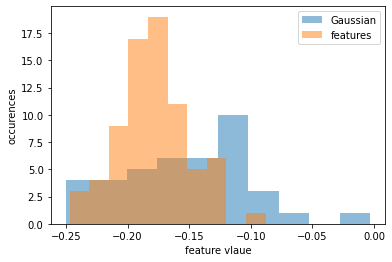

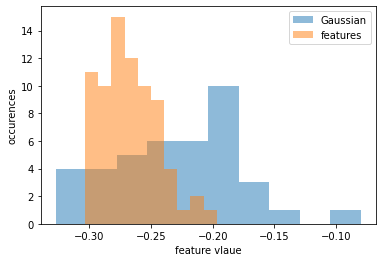

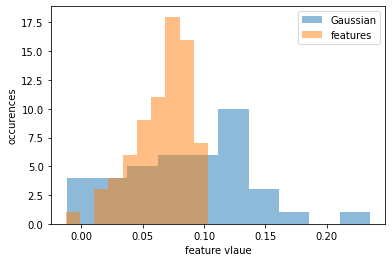

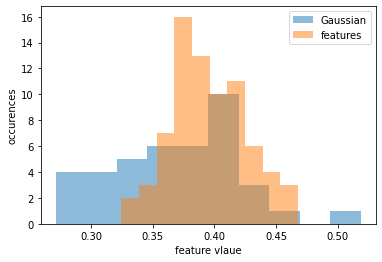

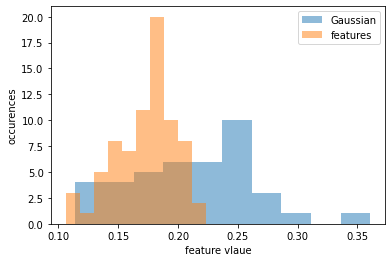

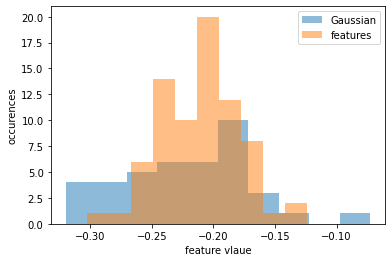

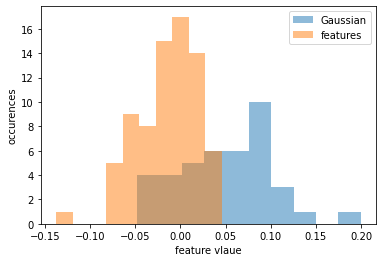

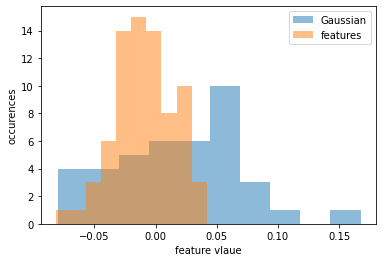

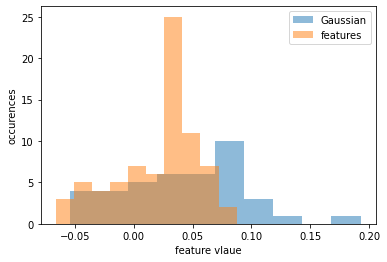

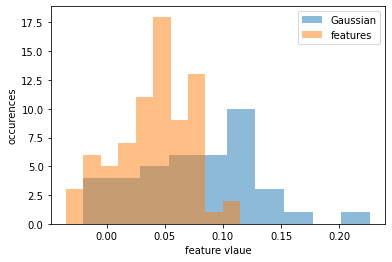

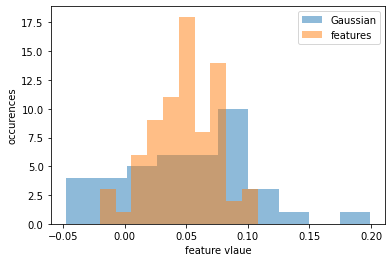

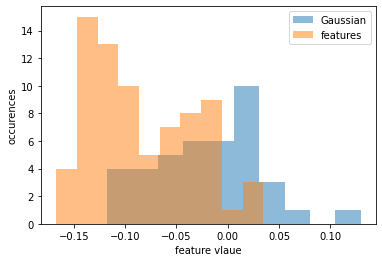

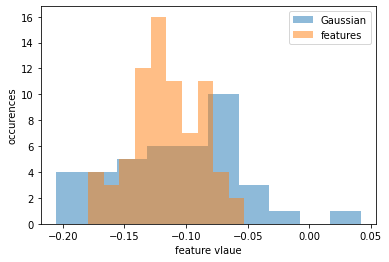

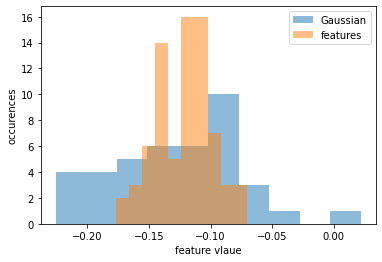

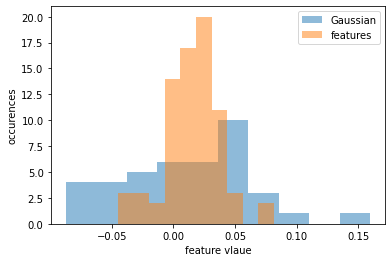

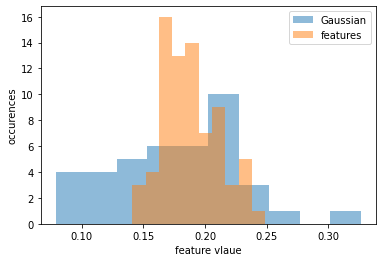

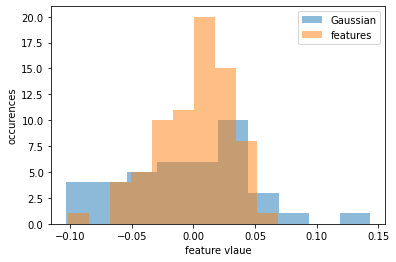

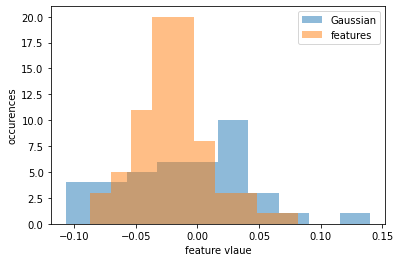

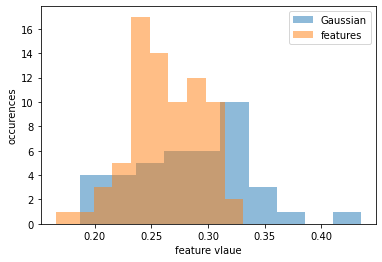

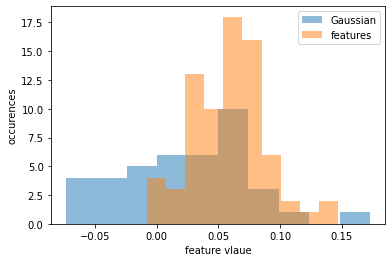

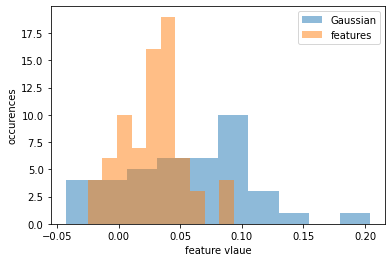

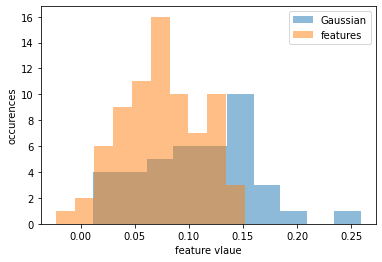

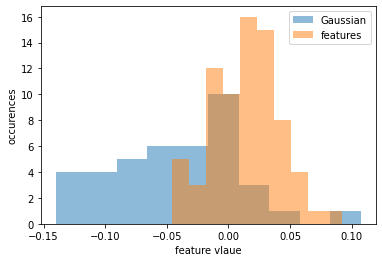

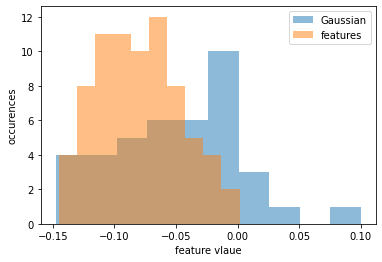

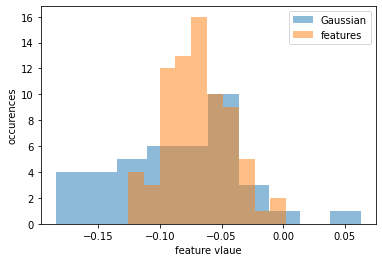

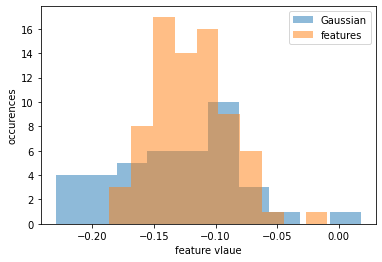

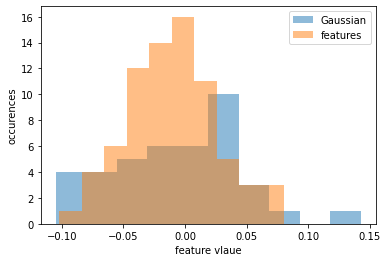

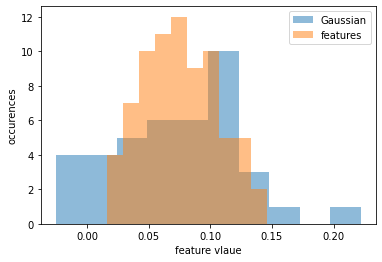

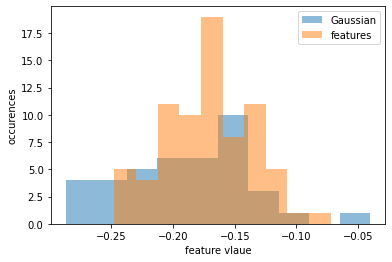

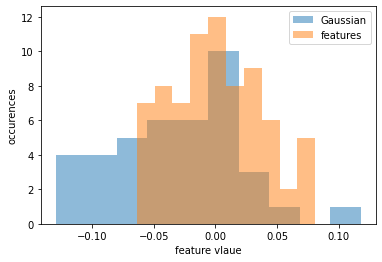

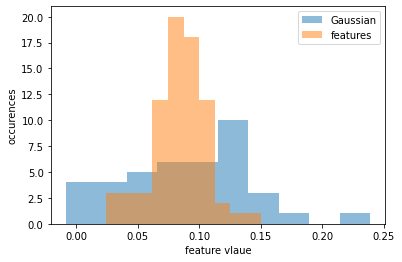

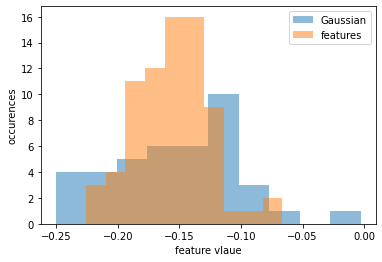

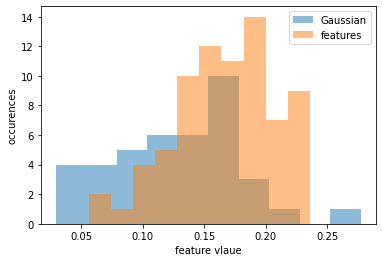

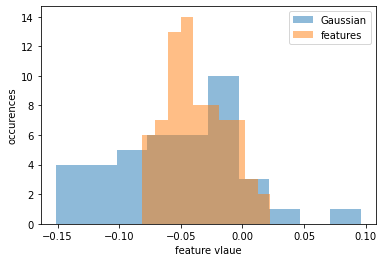

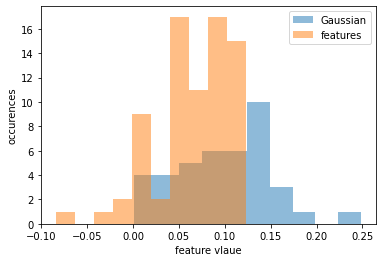

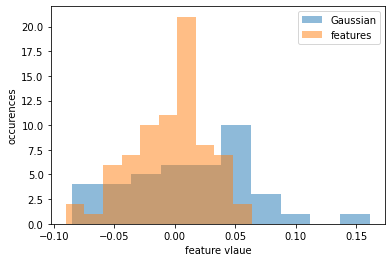

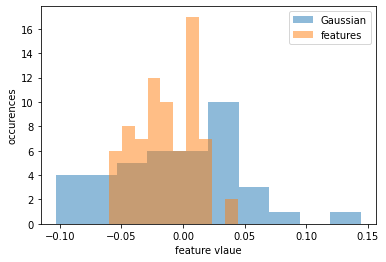

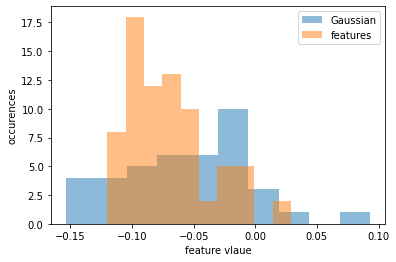

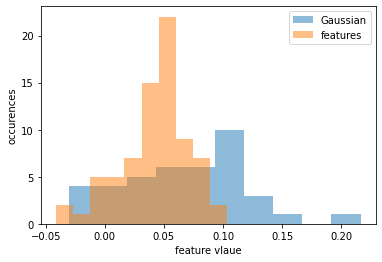

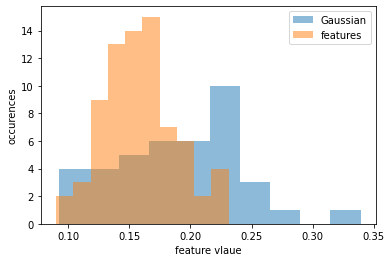

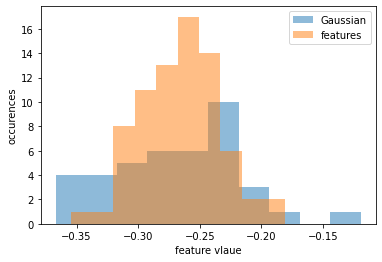

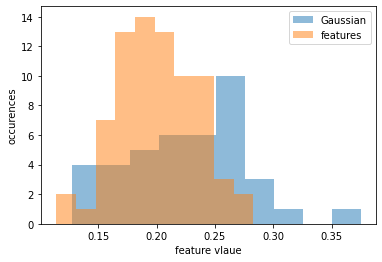

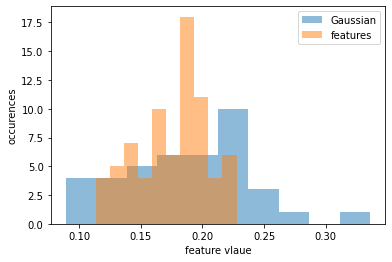

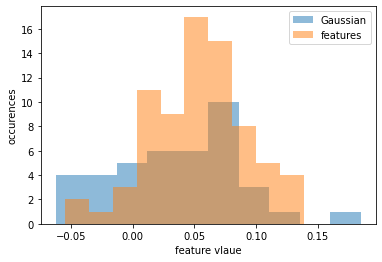

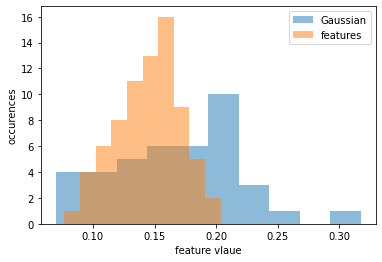

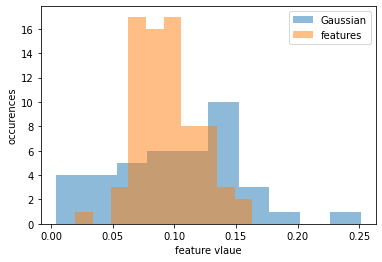

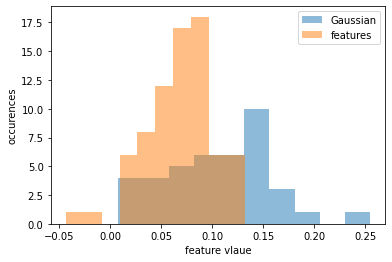

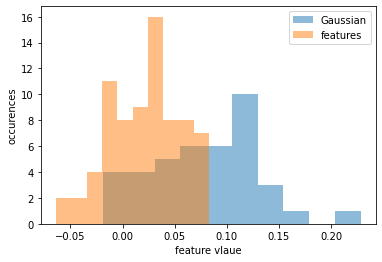

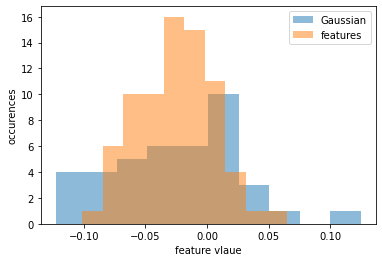

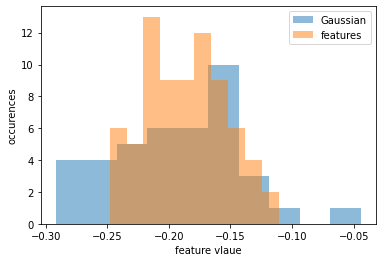

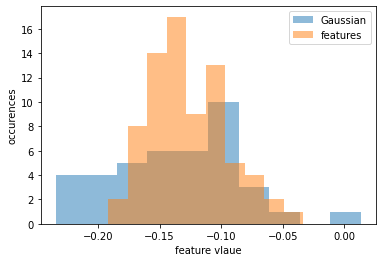

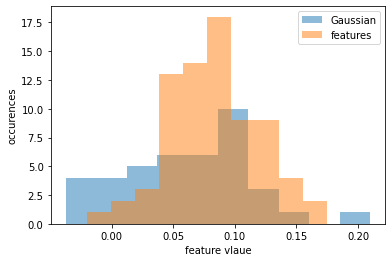

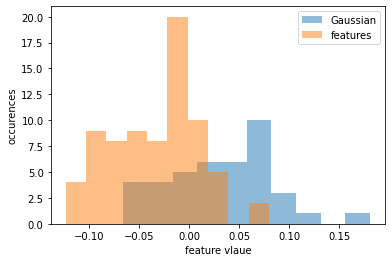

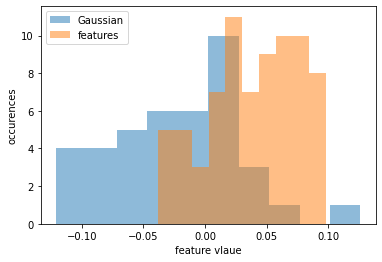

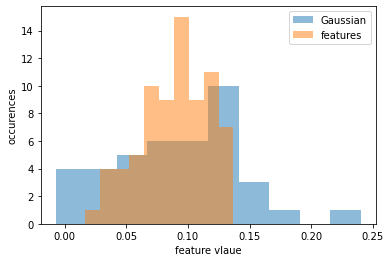

In [57]:
# affichage des distributions des features générées VS réelles pour une personne donnée


features_test_p =np.array(encodings_db2_train_model1[np.where(classes_db2_train_model1 == 'Person01')[0]])
gen_features_gauss, gen_classes_gauss = generate_gauss(best_sigma, encodings_db2_train_model2,  poses, classes_db2_train_model2, best_generate)
gen_features_gauss_test= np.array(gen_features_gauss[np.where(gen_classes_gauss == 'Person01')[0]])
for f in range(features.shape[1]):
    plt.figure()
    plt.hist(gen_features_gauss_test[:, f], bins = 10, alpha=0.5)
    plt.hist(features_test_p[:, f], bins=10, alpha=0.5)
    plt.legend(['Gaussian', 'features'])
    plt.ylabel('occurences')
    plt.xlabel('feature vlaue')

In [53]:
#################################################
######## SUITE PROGRAMME PRINCIPAL ##############
######## estimateur  en fonction de la distribution  ##############
######## analyser la distribution des features   ##############
#################################################

# detection des deviations moyennes pour chaque features

deviation_plus_vect = []   # vecteur des deviation max par rapport a la moyenne (all features, all classes)
deviation_moins_vect = [] # vecteur des deviation min par rapport a la moyenne (all features, all classes)

classes_train = []
for person in classes_db2_train_model2: # parcourir par personne 
    
    enc =np.array(encodings[np.where(classes == person)[0]])
    enc_0 = np.array(encodings_db2_train_model2[np.where(classes_db2_train_model2 == person)[0]])

    # calcul des déviations de chaque feature par rapport à celle de la pose 0

    deviation_plus = []
    deviation_moins = []
    
    for i in range (features_nb):

        deviation_plus.append(np.max(enc[:,i]) - (enc_0[:,i]))
        deviation_moins.append((enc_0[:,i]) - np.min(enc[:,i]))
    deviation_plus = np.array(deviation_plus)
    deviation_moins = np.array(deviation_moins)
    #print("deviation_plus", deviation_plus.shape)
    #print("deviation_moins", deviation_moins.shape)

    deviation_plus_vect.append(deviation_plus)
    deviation_moins_vect.append(deviation_moins)

    
    classes_train.append(person)
   # for feature in features_nb:
deviation_plus_vect = np.array(deviation_plus_vect)
deviation_moins_vect = np.array(deviation_moins_vect)
print("deviation_plus_vect.shape, deviation_moins_vect.shape", deviation_plus_vect.shape, deviation_moins_vect.shape)
classes_train =np.array(classes_train)
print("classes_train.shape", classes_train.shape)
#print(classes_train)
mean_deviation_plus =[] # valeur moyenne des déviations max pour toutes les personnes
mean_deviation_moins =[] # valeur moyenne des déviations min pour toutes les personnes
for i in range(features_nb):
    mean_deviation_plus.append(np.mean(deviation_plus_vect[:,i]))
    mean_deviation_moins.append(np.mean(deviation_moins_vect[:,i]))
mean_deviation_plus=np.array(mean_deviation_plus)
mean_deviation_moins=np.array(mean_deviation_moins)
#print("mean_deviation_plus",mean_deviation_plus)
#print("mean_deviation_moins",mean_deviation_moins)

#plt.plot(mean_deviation_plus)
#plt.plot(mean_deviation_moins)




deviation_plus_vect.shape, deviation_moins_vect.shape (15, 128, 1) (15, 128, 1)
classes_train.shape (15,)


In [28]:
# tester les différentes classifieurs sur la base augmenté 

def trunc_gauss(mu, sigma, bottom, top, features_nb):
    a=[]

    
    for i in range (features_nb):
        
        x= random.gauss(mu[i],sigma)
        
        while (bottom[i] <= x <= top[i]) == False:
            x=random.gauss(mu[i],sigma)
            
        a.append(x)
    return a


max_Accuracy_KNN_gauss_based_features = 0
max_Accuracy_SVC_gauss_based_features = 0
max_Accuracy_LR_gauss_based_features = 0
max_Accuracy_RF_gauss_based_features = 0
best_sigma_SVC = 0
best_sigma_KNN = 0
best_sigma_LR = 0
best_sigma_RF = 0
best_number_KNN = 0
best_number_SVC = 0
best_number_LR = 0
best_number_RF = 0

for sigma in np.arange(0.01, 0.1, 0.005):
    print("sigma =", sigma)
    for generated_vectors in [40, 100, 200]:
        gen_encodings=[]
        classes_gen = []
        print("generated number", generated_vectors)

        for person in classes_db2_train_model2:

            enc =np.array(encodings_db2_train_model2[np.where(classes_db2_train_model2 == person)[0]])
            enc_gen = [] 
            mu = enc[0]
            botton = enc[0]-mean_deviation_moins
            top = enc[0]+mean_deviation_plus
            bottom = np.array(botton)
            top = np.array(top)
    
    
        
    
            for i in range(generated_vectors): 
                temp = trunc_gauss(mu, sigma, bottom, top, features_nb)
                enc_gen.append(temp)

            for i in range (generated_vectors):
                classes_gen.append(person)
                gen_encodings.append(enc_gen[i])
        gen_encodings = np.array(gen_encodings)
        classes_gen = np.array(classes_gen)
    #print("step 3")    
    ########### Etape3 : Contaténer les encodings (réels + générés)#################
        encodings_db2_train_model3=np.concatenate((gen_encodings, encodings_db2_train_model2), axis=0)
        classes_db2_train_model3=np.concatenate((classes_gen, classes_db2_train_model2), axis=0)
        print('encodings_db2_train_model3 shape:', encodings_db2_train_model3.shape)
        print('classes_db2_train_model3 shape:', classes_db2_train_model3.shape)

        print('Fitting  ...')
        KNN_clf.fit (encodings_db2_train_model3 , classes_db2_train_model3)
        SVC_clf.fit (encodings_db2_train_model3 , classes_db2_train_model3)
        LR_clf.fit (encodings_db2_train_model3 , classes_db2_train_model3)
    
        RF_clf.fit (encodings_db2_train_model3 , classes_db2_train_model3)
        print("gen_encodings.shape",gen_encodings.shape) 
        print("classes_gen.shape",classes_gen.shape)

        print('Evaluate classifiers')
# Evaluate the Knn algorithm
        Accuracy_KNN_gauss_based_features = accuracy_score(classes_db2_test_model2, KNN_clf.predict(encodings_db2_test_model2))*100
        Accuracy_SVC_gauss_based_features = accuracy_score(classes_db2_test_model2, SVC_clf.predict(encodings_db2_test_model2))*100
        Accuracy_LR_gauss_based_features = accuracy_score(classes_db2_test_model2, LR_clf.predict(encodings_db2_test_model2))*100
        Accuracy_RF_gauss_based_features = accuracy_score(classes_db2_test_model2, RF_clf.predict(encodings_db2_test_model2))*100
        if (Accuracy_KNN_gauss_based_features > max_Accuracy_KNN_gauss_based_features):
            max_Accuracy_KNN_gauss_based_features = Accuracy_KNN_gauss_based_features
            best_sigma_KNN = sigma
            best_number_KNN = generated_vectors
        if (Accuracy_SVC_gauss_based_features > max_Accuracy_SVC_gauss_based_features):
            max_Accuracy_SVC_gauss_based_features = Accuracy_SVC_gauss_based_features
            best_sigma_SVC = sigma
            best_number_SVC = generated_vectors
        if (Accuracy_LR_gauss_based_features > max_Accuracy_LR_gauss_based_features):
            max_Accuracy_LR_gauss_based_features = Accuracy_LR_gauss_based_features
            best_sigma_LR = sigma
            best_number_LR = generated_vectors
        if (Accuracy_RF_gauss_based_features > max_Accuracy_RF_gauss_based_features):
            max_Accuracy_RF_gauss_based_features = Accuracy_RF_gauss_based_features
            best_sigma_RF = sigma
            best_number_RF = generated_vectors

        print("generated vectors number: ", generated_vectors)

        evaluation_gauss_prediction ={'KNN_gauss_prediction :': Accuracy_KNN_gauss_based_features, \
                                     'SVC_gauss_prediction' :Accuracy_SVC_gauss_based_features,\
                                  'LR_gauss_prediction':Accuracy_LR_gauss_based_features,\
                                  'RF_gauss_prediction':Accuracy_RF_gauss_based_features}
        for i in evaluation_gauss_prediction.items():
            print(i) 
        for i in evaluation_reduced_dataset.items():
            print(i)

sigma = 0.01
generated number 40
encodings_db2_train_model3 shape: (615, 128)
classes_db2_train_model3 shape: (615,)
Fitting  ...
gen_encodings.shape (600, 128)
classes_gen.shape (600,)
Evaluate classifiers
generated vectors number:  40
('KNN_gauss_prediction :', 91.86935371785962)
('SVC_gauss_prediction', 92.14732453092425)
('LR_gauss_prediction', 91.86935371785962)
('RF_gauss_prediction', 83.66921473245309)
('KNN_reduced_dataset :', 91.73036831132731)
('SVC_reduced_dataset', 91.73036831132731)
('LR_reduced_dataset', 89.64558721334261)
('RF_reduced_dataset', 86.03196664350243)
generated number 100
encodings_db2_train_model3 shape: (1515, 128)
classes_db2_train_model3 shape: (1515,)
Fitting  ...
gen_encodings.shape (1500, 128)
classes_gen.shape (1500,)
Evaluate classifiers
generated vectors number:  100
('KNN_gauss_prediction :', 91.86935371785962)
('SVC_gauss_prediction', 91.79986101459346)
('LR_gauss_prediction', 91.66087560806116)
('RF_gauss_prediction', 87.42182070882556)
('KNN_red

gen_encodings.shape (3000, 128)
classes_gen.shape (3000,)
Evaluate classifiers
generated vectors number:  200
('KNN_gauss_prediction :', 91.31341209173037)
('SVC_gauss_prediction', 92.35580264072273)
('LR_gauss_prediction', 91.86935371785962)
('RF_gauss_prediction', 90.54899235580264)
('KNN_reduced_dataset :', 91.73036831132731)
('SVC_reduced_dataset', 91.73036831132731)
('LR_reduced_dataset', 89.64558721334261)
('RF_reduced_dataset', 86.03196664350243)
sigma = 0.034999999999999996
generated number 40
encodings_db2_train_model3 shape: (615, 128)
classes_db2_train_model3 shape: (615,)
Fitting  ...
gen_encodings.shape (600, 128)
classes_gen.shape (600,)
Evaluate classifiers
generated vectors number:  40
('KNN_gauss_prediction :', 92.28630993745656)
('SVC_gauss_prediction', 92.00833912439194)
('LR_gauss_prediction', 92.14732453092425)
('RF_gauss_prediction', 90.7574704656011)
('KNN_reduced_dataset :', 91.73036831132731)
('SVC_reduced_dataset', 91.73036831132731)
('LR_reduced_dataset', 89.

generated vectors number:  100
('KNN_gauss_prediction :', 91.52189020152885)
('SVC_gauss_prediction', 91.86935371785962)
('LR_gauss_prediction', 91.79986101459346)
('RF_gauss_prediction', 90.96594857539958)
('KNN_reduced_dataset :', 91.73036831132731)
('SVC_reduced_dataset', 91.73036831132731)
('LR_reduced_dataset', 89.64558721334261)
('RF_reduced_dataset', 86.03196664350243)
generated number 200
encodings_db2_train_model3 shape: (3015, 128)
classes_db2_train_model3 shape: (3015,)
Fitting  ...
gen_encodings.shape (3000, 128)
classes_gen.shape (3000,)
Evaluate classifiers
generated vectors number:  200
('KNN_gauss_prediction :', 91.2439193884642)
('SVC_gauss_prediction', 91.52189020152885)
('LR_gauss_prediction', 91.79986101459346)
('RF_gauss_prediction', 91.31341209173037)
('KNN_reduced_dataset :', 91.73036831132731)
('SVC_reduced_dataset', 91.73036831132731)
('LR_reduced_dataset', 89.64558721334261)
('RF_reduced_dataset', 86.03196664350243)
sigma = 0.05999999999999999
generated number

encodings_db2_train_model3 shape: (1515, 128)
classes_db2_train_model3 shape: (1515,)
Fitting  ...
gen_encodings.shape (1500, 128)
classes_gen.shape (1500,)
Evaluate classifiers
generated vectors number:  100
('KNN_gauss_prediction :', 91.591382904795)
('SVC_gauss_prediction', 91.66087560806116)
('LR_gauss_prediction', 92.2168172341904)
('RF_gauss_prediction', 92.42529534398888)
('KNN_reduced_dataset :', 91.73036831132731)
('SVC_reduced_dataset', 91.73036831132731)
('LR_reduced_dataset', 89.64558721334261)
('RF_reduced_dataset', 86.03196664350243)
generated number 200
encodings_db2_train_model3 shape: (3015, 128)
classes_db2_train_model3 shape: (3015,)
Fitting  ...
gen_encodings.shape (3000, 128)
classes_gen.shape (3000,)
Evaluate classifiers
generated vectors number:  200
('KNN_gauss_prediction :', 91.79986101459346)
('SVC_gauss_prediction', 91.93884642112579)
('LR_gauss_prediction', 92.28630993745656)
('RF_gauss_prediction', 91.10493398193191)
('KNN_reduced_dataset :', 91.73036831132

In [29]:
# affichage de best accuracy and parametres of each classifier 
print(max_Accuracy_KNN_gauss_based_features)
print(best_sigma_KNN, best_number_KNN)
print(max_Accuracy_SVC_gauss_based_features)
print(best_sigma_SVC, best_number_SVC)
print(max_Accuracy_LR_gauss_based_features)
print(best_sigma_LR, best_number_LR)
print(max_Accuracy_RF_gauss_based_features)
print(best_sigma_RF, best_number_RF)

92.35580264072273
0.06499999999999999 40
93.12022237665045
0.07499999999999998 40
92.84225156358582
0.07499999999999998 40
92.42529534398888
0.07999999999999999 100


In [32]:
# générer la meilleure distribution

sigma = best_sigma_SVC
generated_vectors = 40
gen_encodings=[]
classes_gen = []
        

for person in classes_db2_train_model2:

    enc =np.array(encodings_db2_train_model2[np.where(classes_db2_train_model2 == person)[0]])
    enc_gen = [] 
    mu = enc[0]
    botton = enc[0]-mean_deviation_moins
    top = enc[0]+mean_deviation_plus
    bottom = np.array(botton)
    top = np.array(top)
    
    
        
    
    for i in range(generated_vectors): 
        temp = trunc_gauss(mu, sigma, bottom, top, features_nb)
        enc_gen.append(temp)

    for i in range (generated_vectors):
        classes_gen.append(person)
        gen_encodings.append(enc_gen[i])
gen_encodings = np.array(gen_encodings)
classes_gen = np.array(classes_gen)



<ipython-input-38-224d02792cb8>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


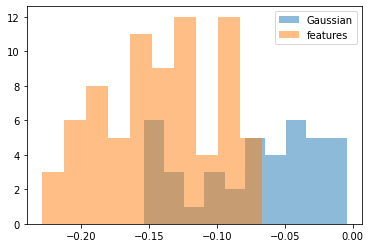

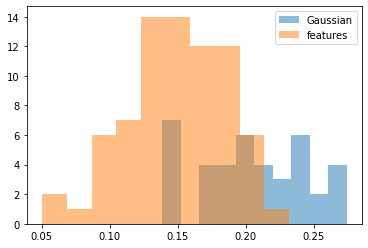

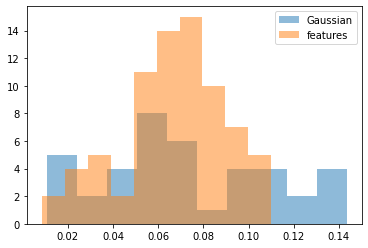

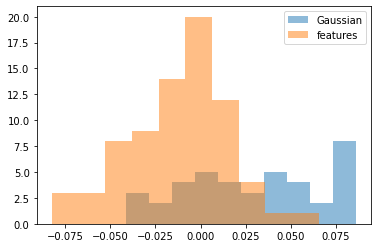

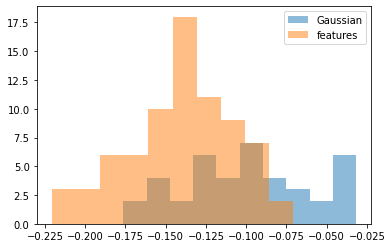

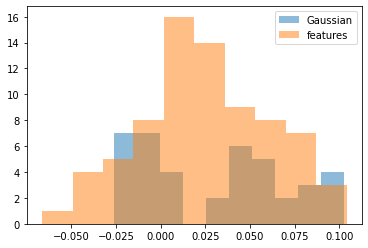

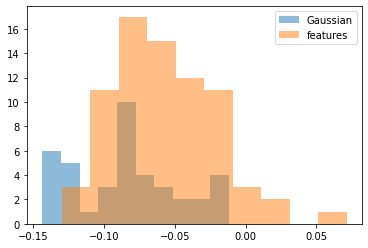

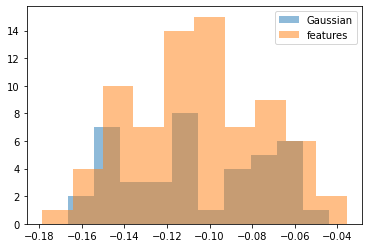

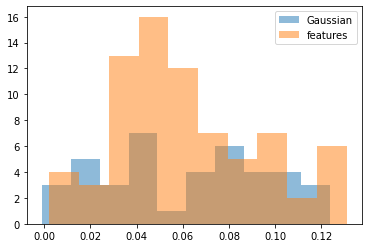

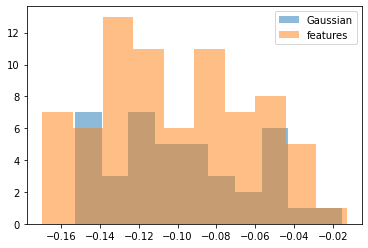

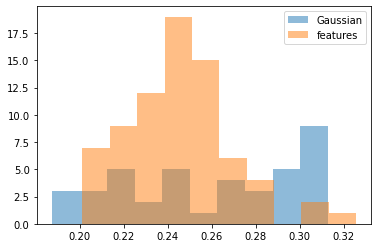

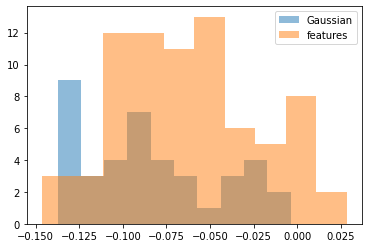

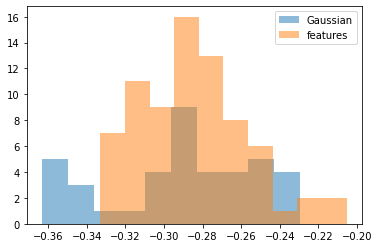

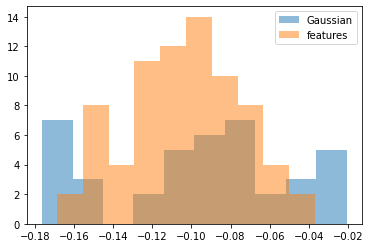

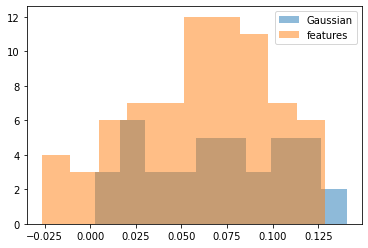

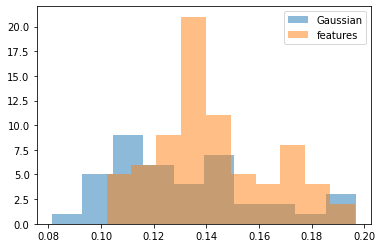

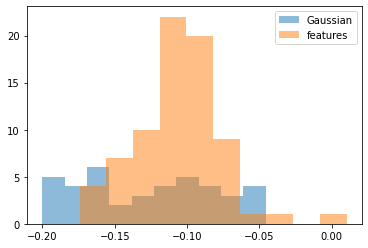

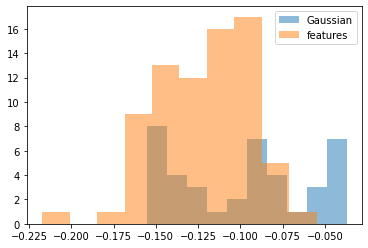

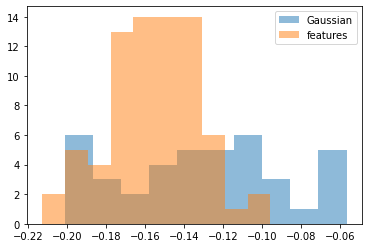

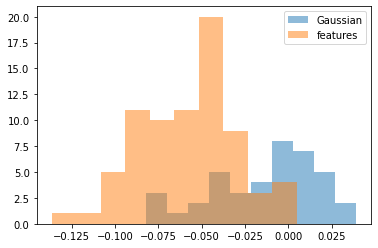

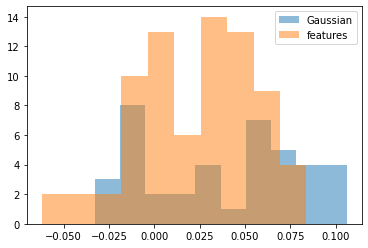

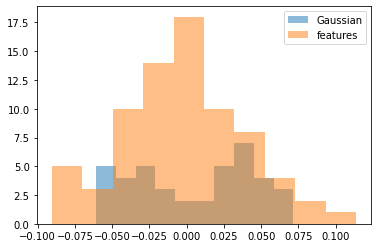

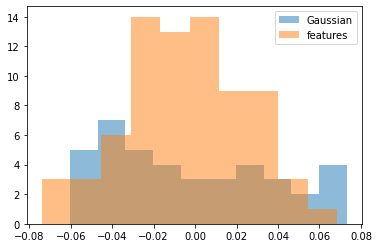

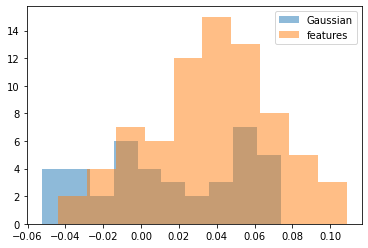

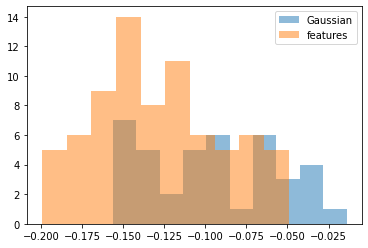

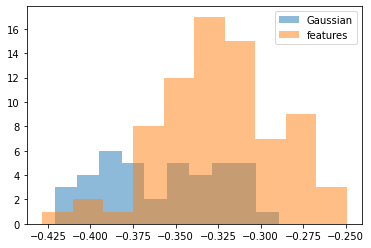

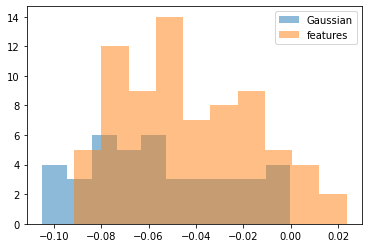

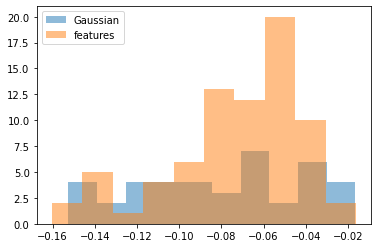

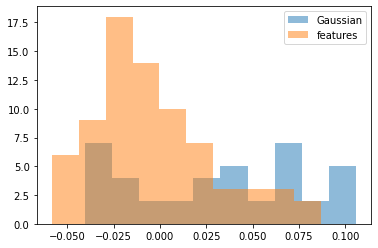

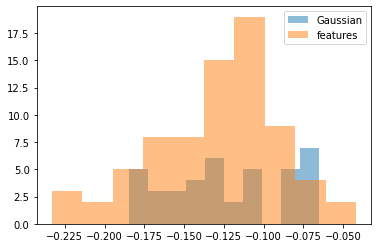

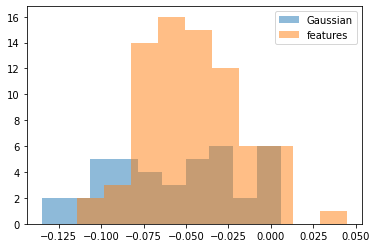

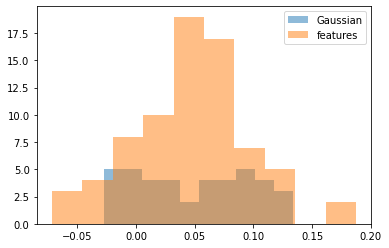

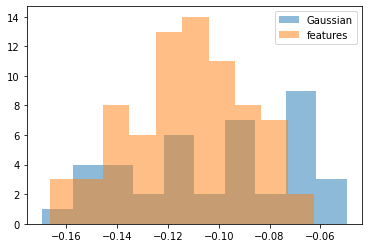

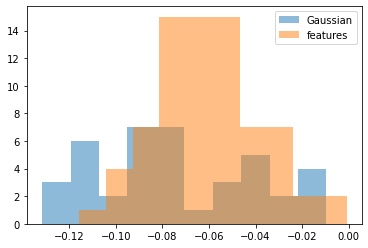

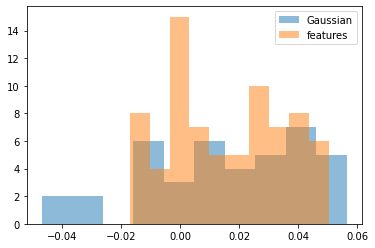

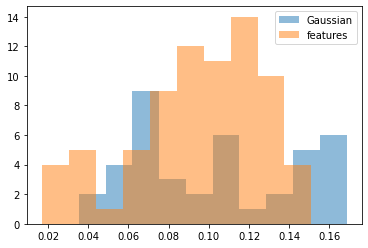

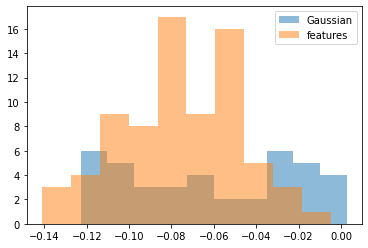

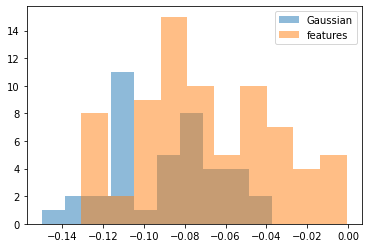

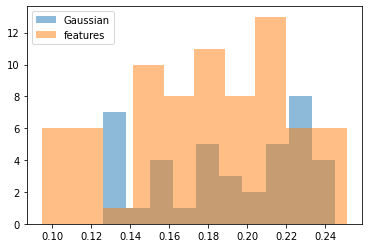

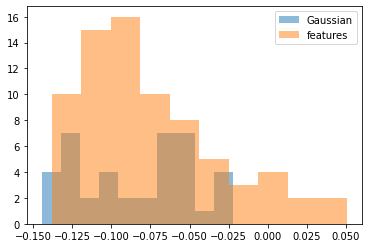

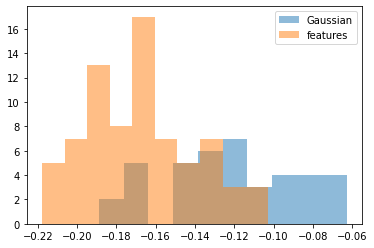

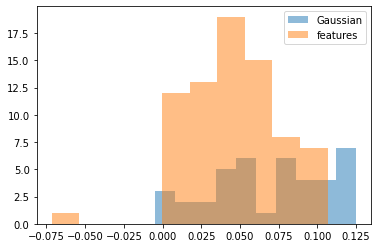

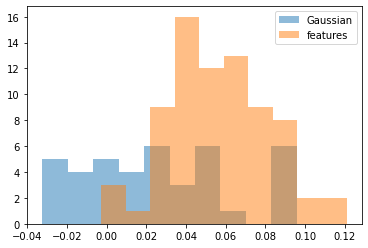

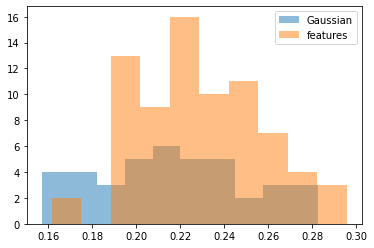

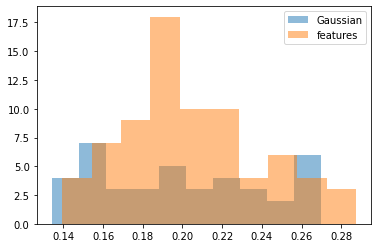

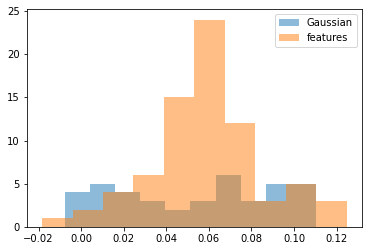

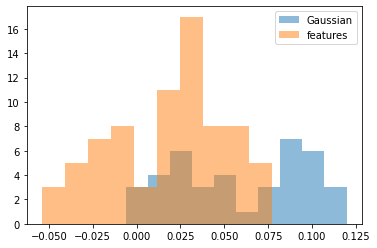

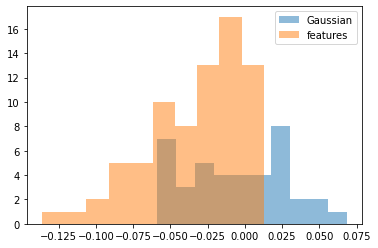

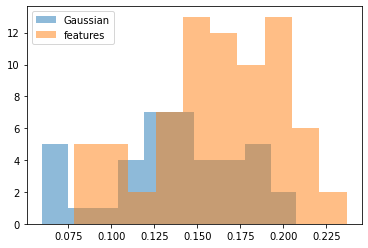

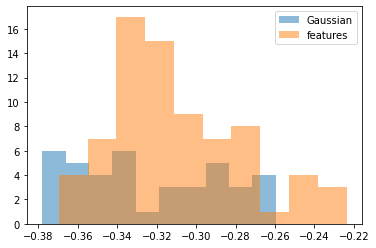

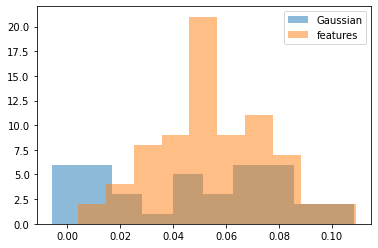

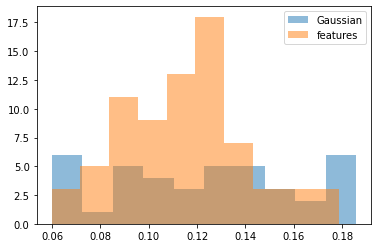

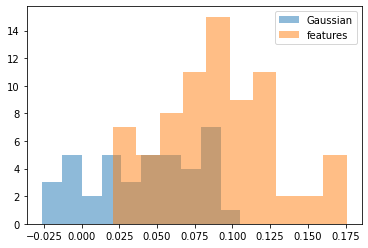

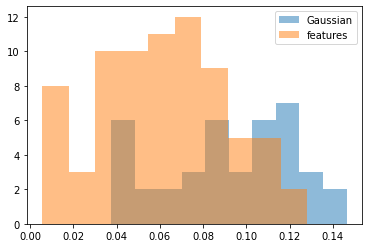

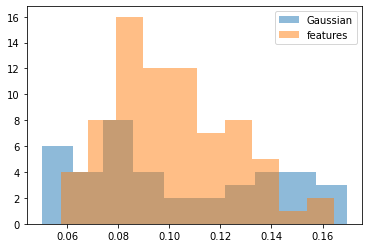

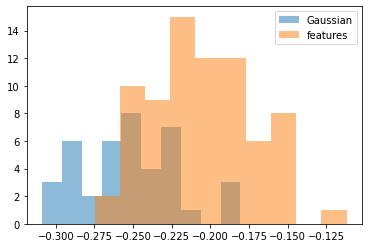

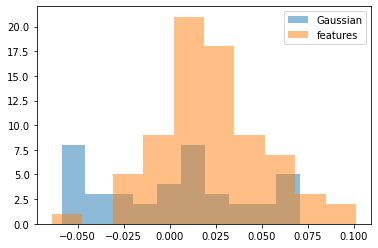

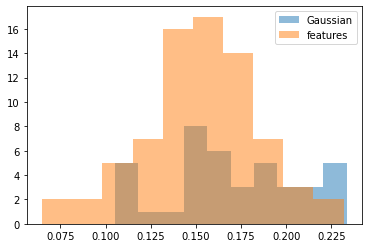

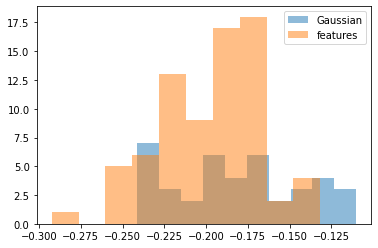

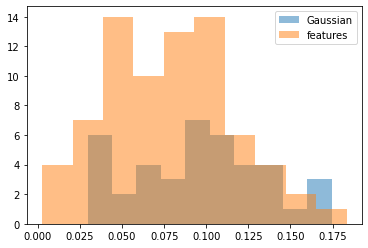

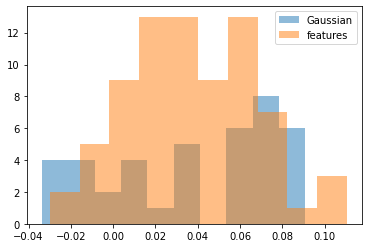

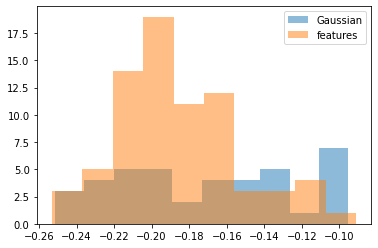

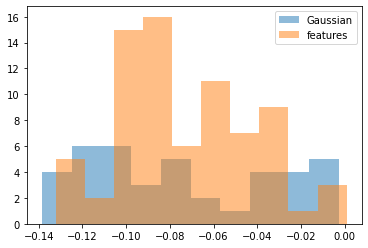

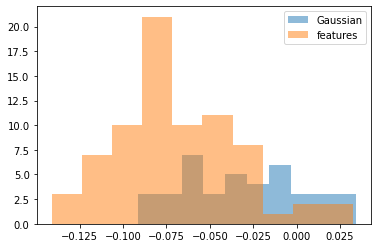

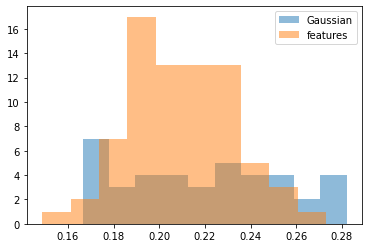

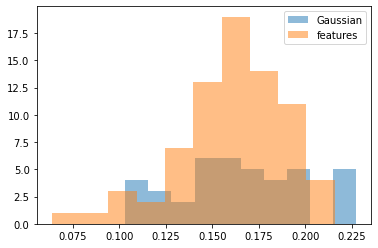

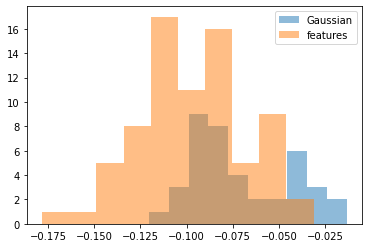

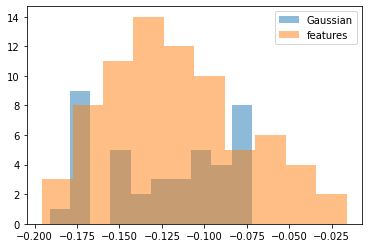

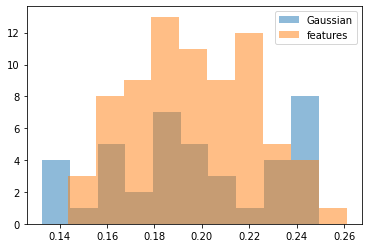

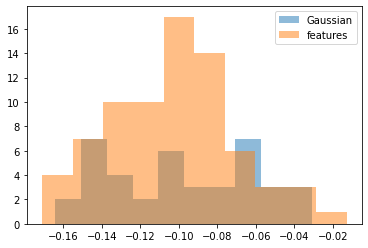

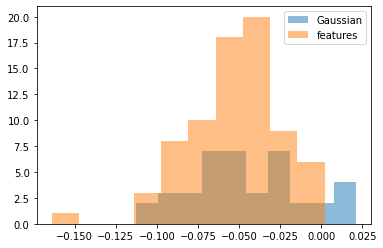

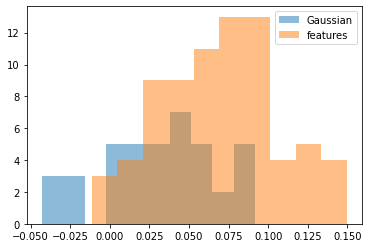

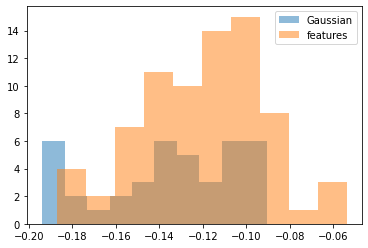

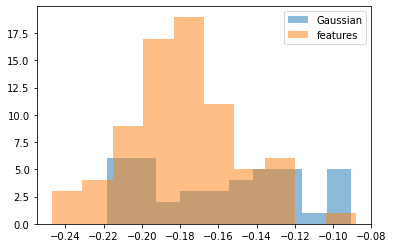

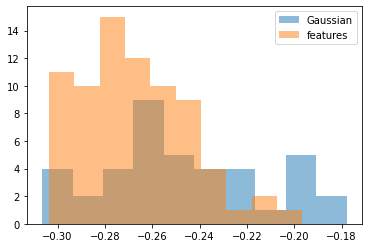

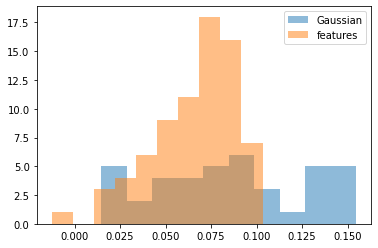

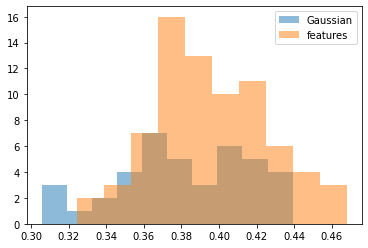

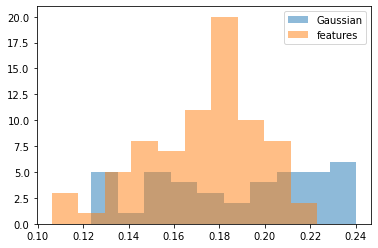

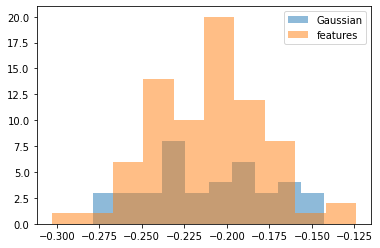

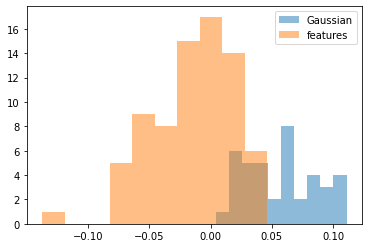

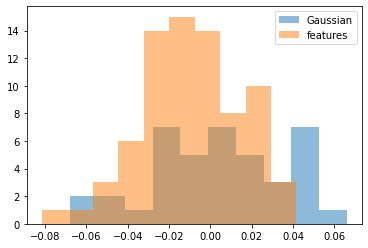

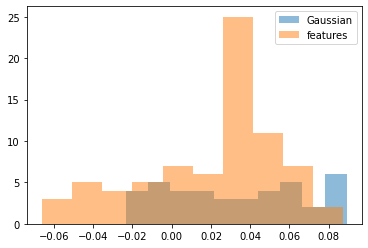

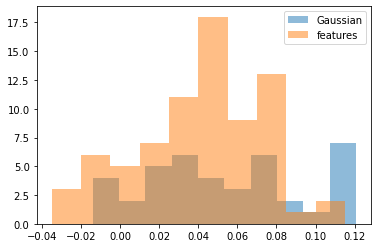

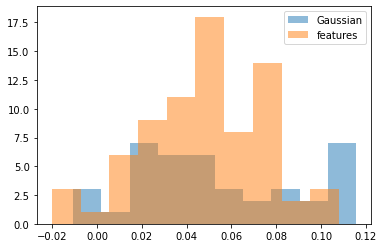

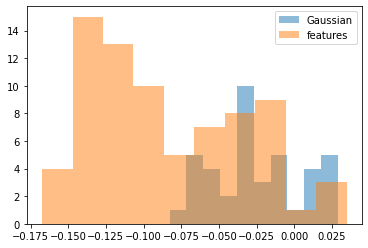

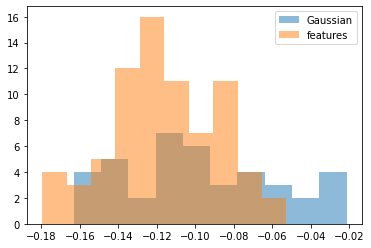

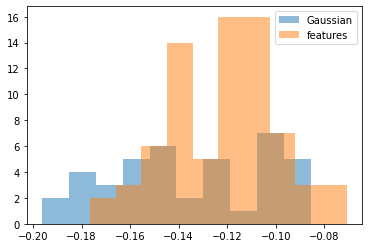

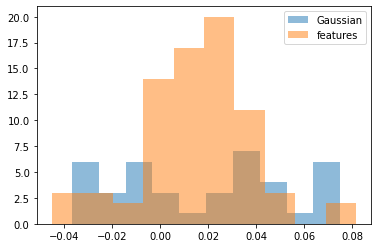

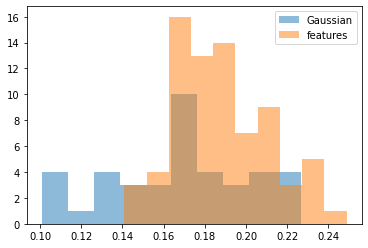

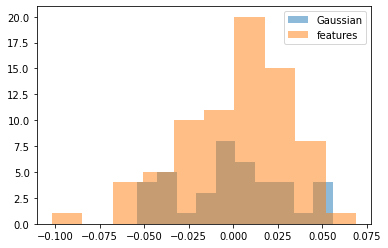

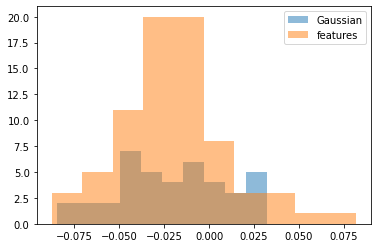

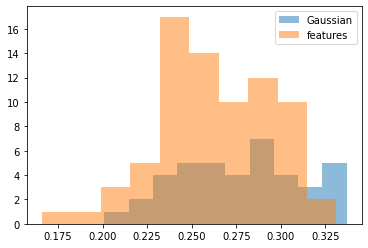

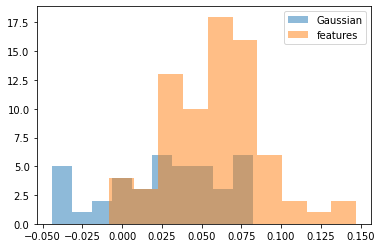

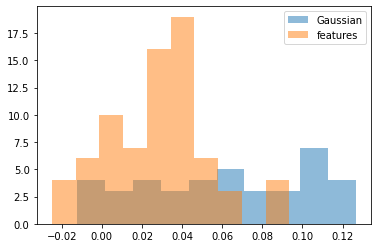

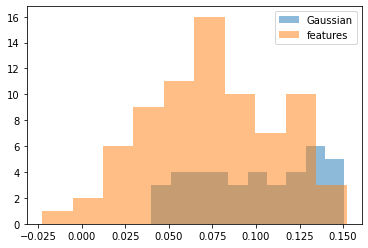

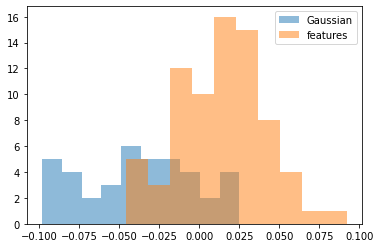

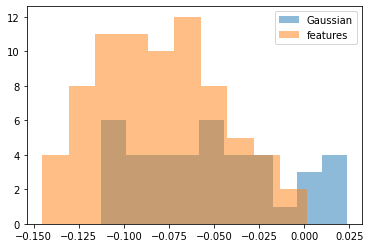

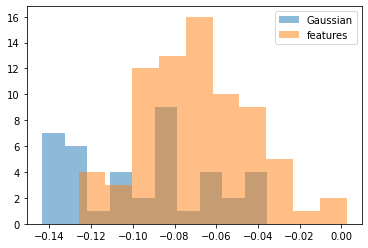

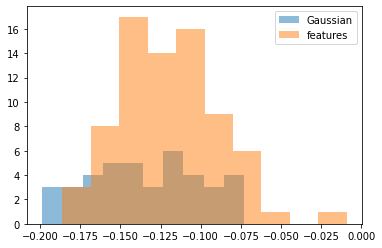

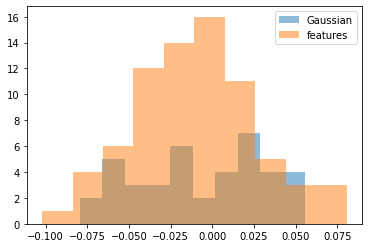

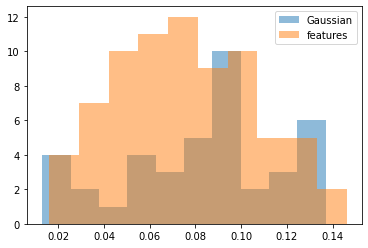

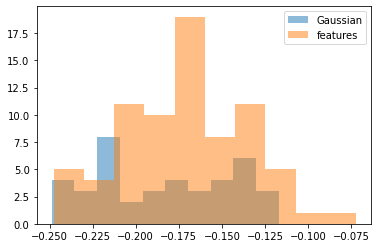

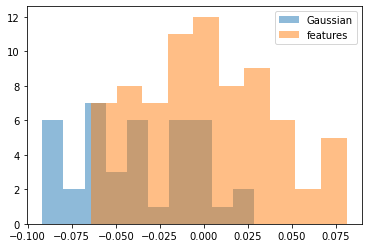

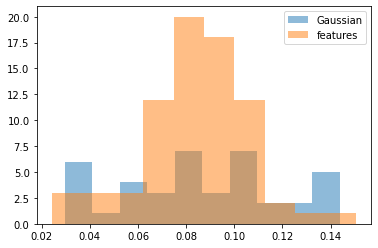

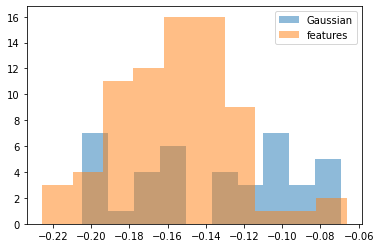

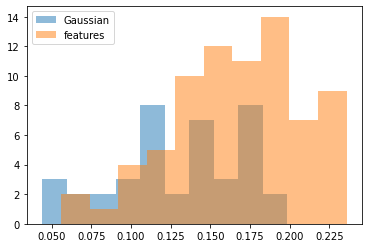

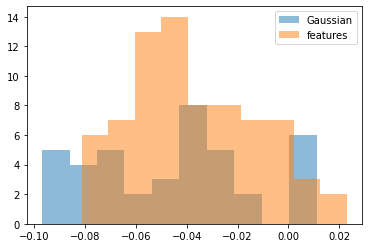

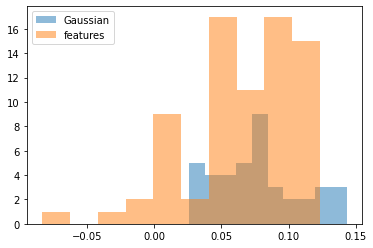

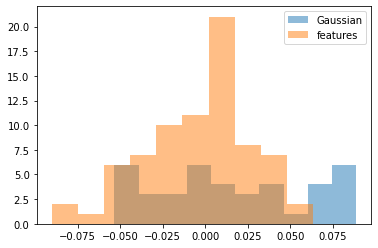

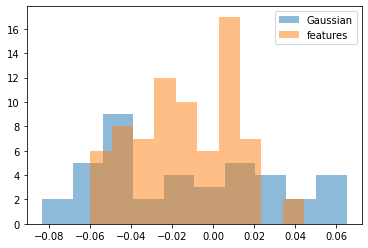

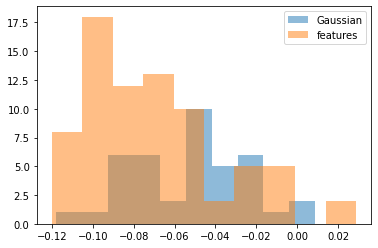

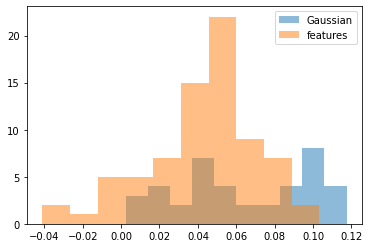

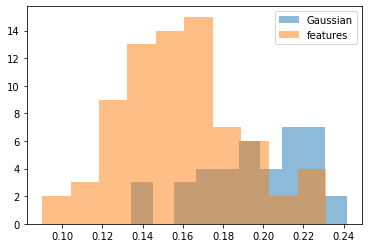

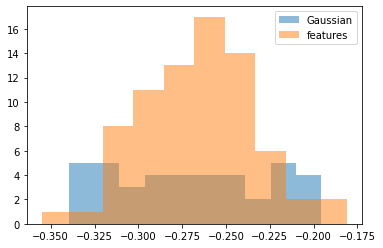

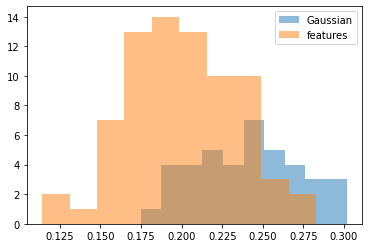

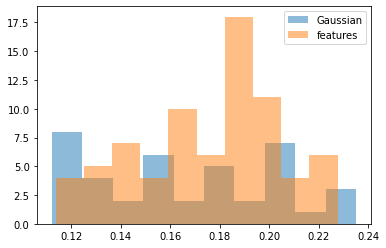

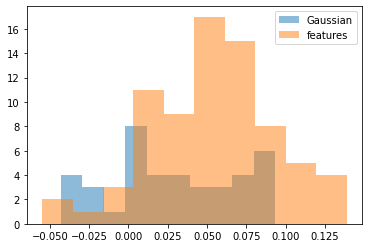

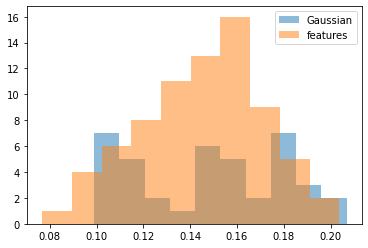

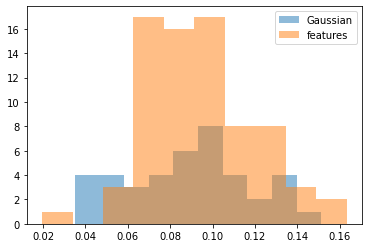

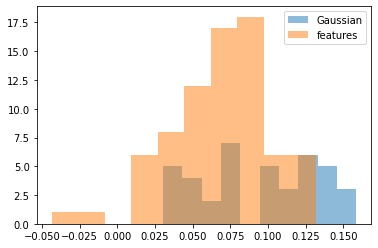

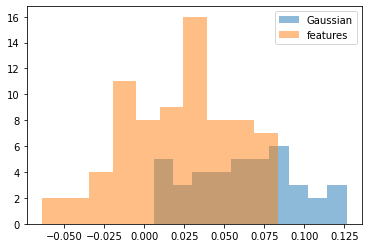

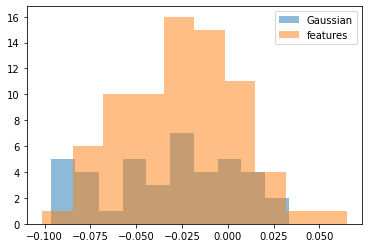

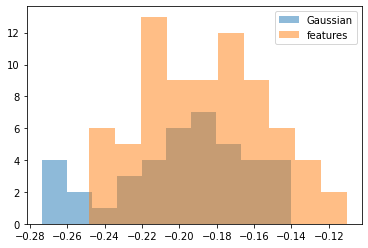

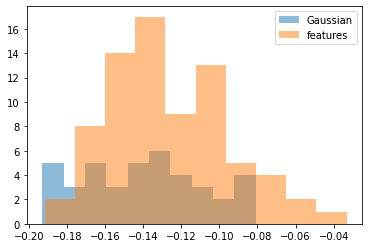

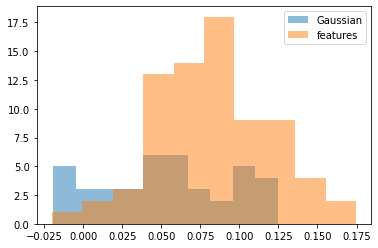

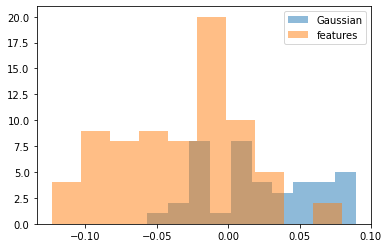

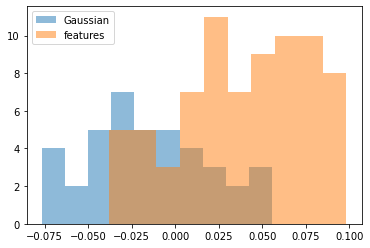

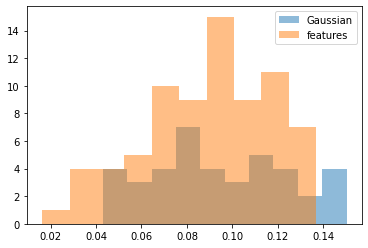

In [38]:
# affichage des distributions des features générées VS réelles pour une personne donnée

gen_encodings_p= np.array(gen_encodings[np.where(classes_gen == 'Person01')[0]])
features_test_p =np.array(encodings_db2_train_model1[np.where(classes_db2_train_model1 == 'Person01')[0]])
for f in range(features.shape[1]):
    plt.figure()
    plt.hist(gen_encodings_p[:, f], bins = 10, alpha=0.5)
    plt.hist(features_test_p[:, f], bins=10, alpha=0.5)
    plt.legend(['Gaussian', 'features'])

In [ ]:
db2 training samples (model 2): 15
db2 test samples (model 2): 1439
Fitting  ...
Evaluate classifiers ...
('KNN :', 99.58333333333333)
('SVC', 99.16666666666667)
('LR', 98.95833333333334)
('RF', 99.58333333333333)
('KNN_reduced_dataset :', 91.73036831132731)
('SVC_reduced_dataset', 91.73036831132731)
('LR_reduced_dataset', 89.64558721334261)
('RF_reduced_dataset', 
 
KNN : 91.73036831132731 //// 92.35580264072273   ///  99.58333333333333   
SVC : 91.73036831132731 //// 93.12022237665045   
LR : 89.64558721334261  //// 92.84225156358582 
RF : 85.89298123697013 //// 92.42529534398888
0.06499999999999999 40

0.07499999999999998 40

0.07499999999999998 40
92.42529534398888
0.07999999999999999 100